One instance for each cyclic stock

In [1]:
specified_commision = 0.00125

# Retrieve Data

In [2]:
import pandas as pd
import pandas_ta as ta

from datetime import date, datetime
# data retrieval 
# < insert code > 

def retrieve_data(ticker = 'xom'): 

    df = pd.read_csv(f'data_repair/{ticker}_retrived_close.csv')
    df['Date'] = df.apply(lambda x: datetime.strptime(x.Date, '%Y-%m-%d').date(), axis = 1)
    df = df.rename(columns = {'close':'Close'})
    df = df.set_index('Date')

    # perfect macd
    df1 = df.copy()[[]]
    df1['Date1'] = df1.index
    for index in range(26, 0, -1): 
        df1[f'Tm{index}_Price'] = df['Close'].shift(index)
    df1 = pd.concat([df1, df['Close']], axis = 1)
    for index in range(1, 14, 1): 
        df1[f'Tp{index}_Price'] = df['Close'].shift(-index)
    df1 = df1[df1['Date1'] >= date(2019, 1, 1)][df1['Date1'] < date(2024, 1, 1)]
    p_macd = df1.copy() 


    # normal macd
    df1 = df.copy()[[]]
    df1['Date1'] = df1.index
    for index in range(26, 0, -1): 
        df1[f'Tm{index}_Price'] = df['Close'].shift(index)    
    df1 = pd.concat([df1, df['Close']], axis = 1)
    df1 = df1[df1['Date1'] >= date(2019, 1, 1)][df1['Date1'] < date(2024, 1, 1)]
    v_macd = df1.copy() 

    # forecasted macd 
    df1 = df.copy()[[]]
    df1['Date1'] = df1.index
    for index in range(26, 0, -1): 
        df1[f'Tm{index}_Price'] = df['Close'].shift(index)
    df1 = pd.concat([df1, df['Close']], axis = 1)
    df1 = df1[df1['Date1'] >= date(2019, 1, 1)][df1['Date1'] < date(2024, 1, 1)]
    predicted = pd.read_csv(f'{ticker}/data/test/OVERALL_prediction_by_model.csv', index_col='Date')
    predicted = predicted.reset_index(drop = False)
    predicted['Date'] = predicted.apply(lambda x: datetime.strptime(x.Date, '%Y-%m-%d').date(), axis = 1)
    predicted = predicted.set_index('Date')
    predicted = predicted[[col for col in predicted.columns if 'pred' in col]]

    f_macd = pd.concat([df1, predicted], axis = 1)

    return p_macd, v_macd, f_macd

In [3]:
import numpy as np 

def macdWalkthrough(targetdf, initial_capital = 100, c_position = 0, commision = 0):
    trade_history = []

    ar_vmacd = targetdf.to_numpy() 

    target = ar_vmacd

    # 0 - date 
    # 1 - Close 
    # 2 - pct_change 
    # 3 - triggered action 
    # 4 - effective action 
    # 5 - value of investment 
    # 6 - current position 

    # states: 
#     c_position = 0 
#     initial_capital = 100
#     commision = 0.00

    column_names = ['Date', 'Close', 'pct_change', 't_action', 'eff_action', 'value', 'cur_position']

    results = [] 

    for row in range(len(target)):

        item = target[row]
        c_action = item[3]

        # identify effective action 
        if c_action == c_position: item = np.append(item, 0)
        elif c_action == 1 and c_position == 1: item = np.append(item, 0)
        elif c_action == -1 and c_position == 0: item = np.append(item, 0)
        else: item = np.append(item, c_action)


        e_action = item[4]
        if e_action == 1: 
            new_record = {'start': row, 'start_date': item[0], 'start_value': item[1], 'start_capital': results[row - 1][5]}
            trade_history.append(new_record)

            # update 
            if row != 0: item = np.append(item, results[row - 1][5]*(1-commision)) # investment value 
            else: item = np.append(item, initial_capital)
            item = np.append(item, 1) # current position 
            c_position = 1

        elif e_action == -1: 
            item = np.append(item, (results[row - 1][5]*(1+item[2]))*(1-commision))
            item = np.append(item, 0)
            c_position = 0 
            
            update_record = trade_history.pop() # take the lastest record 
            update_record['close'] = row 
            update_record['close_date'] = item[0]
            update_record['close_value'] = item[1]
            update_record['close_capital'] = item[5]
            update_record['close_capital_adj'] = update_record['start_capital'] * (1 + ((update_record['close_value'] - update_record['start_value'])/update_record['start_value']))
            trade_history.append(update_record)            

        elif e_action == 0: 
            if row != 0 :
                if c_position == 1: 
                    item = np.append(item, (results[row - 1][5] * (1+item[2]))) # investment value 
                    item = np.append(item, c_position) # current position             

                elif c_position == 0: 
    #                 print(target[row - 1])
                    item = np.append(item, results[row - 1][5]) # investment value 
                    item = np.append(item, c_position)      
            else: 
                item = np.append(item, initial_capital) # investment value 
                item = np.append(item, c_position)  

        results.append(item)
        
        if row == len(target) - 1 and c_position == 1: 
            update_record = trade_history.pop() # take the lastest record             
            update_record['close'] = row 
            update_record['close_date'] = item[0]
            update_record['close_value'] = item[1] 
            update_record['close_capital'] = item[5]     
            update_record['close_capital_adj'] = update_record['start_capital'] * (1 + ((update_record['close_value'] - update_record['start_value'])/update_record['start_value']))
            
            trade_history.append(update_record)
            
        
    result_df = pd.DataFrame(results, columns = column_names)
    return result_df, trade_history

In [4]:
def technical_indicators(x, st, lt, vanila = 0, lag = 0): 

    # initialize lag 
    if vanila == 1: 
        lag = 0
        rsi_lag = 0 
    else: 
        rsi_lag = 7 # to achieve the usage of half predicted and half historical 

    
    # calculate ema 26
    length = lt    
    ema26 = x[-(length+lag):]
    ema26 = ta.ema(ema26, length = length, adjust = False, min_periods = 1)
    ema26 = ema26.values[-(1+lag):][0]

    # calculate ema12 
    length = st
    ema12 = x[-(length+lag):]
    ema12 = ta.ema(ema12, length = length, adjust = False, min_periods = 1)
    ema12 = ema12.values[-(1+lag):][0]    

    # calculate macd 
    macd = ema12 - ema26
    
    # calculate rsi 
    length = 15
    rsi = x[-(length+rsi_lag):]
    rsi = ta.rsi(rsi, length = 14)
    rsi = rsi.values[-(1+rsi_lag):][0]
    
    return (ema26, ema12, macd, rsi)

# Use Here

In [5]:
ticker = 'ms'
perfect, vanilla, forecasted = retrieve_data(ticker)

/tmp/ipykernel_18429/2251140449.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df1[df1['Date1'] >= date(2019, 1, 1)][df1['Date1'] < date(2024, 1, 1)]
/tmp/ipykernel_18429/2251140449.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df1[df1['Date1'] >= date(2019, 1, 1)][df1['Date1'] < date(2024, 1, 1)]
/tmp/ipykernel_18429/2251140449.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df1[df1['Date1'] >= date(2019, 1, 1)][df1['Date1'] < date(2024, 1, 1)]


### Experiment 1

In [6]:
def experiment1(item, candidate, vanila = 0, lag = 0, buy_threshold = 0, sell_threshold = 0, choice_action = 'macd'):
    
    short = candidate['short']
    long = candidate['long']
    signal = candidate['signal']
    buy_threshold = candidate['buy_threshold']
    sell_threshold = candidate['sell_threshold']
    
      
    # forecasted values (current day)
    results = item.copy()
    
    # obtain ema & rsi values 
    results[['ema26_1', 'ema12_1', 'macd_1', 'rsi_1']] = results.apply(lambda x: technical_indicators(x, st = short, lt = long, vanila = vanila, lag = lag), axis = 1, result_type='expand')
    # ema of MACD 
    results['macd_signal_1'] = ta.ema(results['macd_1'], length = signal, adjust = False, min_periods = 1)
    # MACD Histogram 
    results['macd_div_1'] = results['macd_1'] - results['macd_signal_1']
    # MACD Action 
    results['macd_action_1'] = results.apply(lambda x: 1 if x['macd_div_1'] > buy_threshold else(-1 if x['macd_div_1'] < sell_threshold else 0), axis = 1)

    
    # RSI 
    results['rsi_action1'] = results.apply(lambda x: 1 if x['rsi_1'] < 30 else(-1 if x['rsi_1'] > 70 else 0), axis = 1)
    
    
    # actions for macd 
    if choice_action == 'rsi': 
        print('rsi_chosen')
        results['action'] = results['rsi_action1']
    else: 
        print('macd_chosen')
        results['action'] = results['macd_action_1']
    
    
    # obtain pct_change for outcome computation 
    results['pct_change'] = results['Close'].pct_change() 

    output = results.copy()
    output = output.reset_index(drop = False)
    output = output.fillna(0)    
    output = output[['Date', 'Close', 'pct_change', 'action']]

    return output, results

In [7]:

candidate = {
    'short': 12, 
    'long': 26, 
    'signal': 9, 
    'buy_threshold': 0, 
    'sell_threshold': 0, 
}

targetData = perfect.copy() 
output, workings_df = experiment1(targetData, candidate, vanila = 0, lag = 0, choice_action = 'macd')
df, trades = macdWalkthrough(output, commision = 0.0)

print(len(trades))
df

macd_chosen
39


,Date,Close,pct_change,t_action,eff_action,value,cur_position
0,2019-01-02,34.282745,0.000000,0,0,100.000000,0
1,2019-01-03,33.671761,-0.017822,0,0,100.000000,0
2,2019-01-04,35.046455,0.040826,0,0,100.000000,0
3,2019-01-07,35.394379,0.009927,0,0,100.000000,0
4,2019-01-08,35.173748,-0.006233,0,0,100.000000,0
...,...,...,...,...,...,...,...
1253,2023-12-22,91.513542,-0.002375,-1,0,1067.153006,0
1254,2023-12-26,91.939362,0.004653,-1,0,1067.153006,0
1255,2023-12-27,92.751411,0.008832,-1,0,1067.153006,0
1256,2023-12-28,92.731606,-0.000214,0,0,1067.153006,0


In [8]:

candidate = {
    'short': 12, 
    'long': 26, 
    'signal': 9, 
    'buy_threshold': 0, 
    'sell_threshold': 0, 
}

targetData = perfect.copy() 
output, workings_df = experiment1(targetData, candidate, vanila = 0, lag = 0, choice_action = 'rsi')
df, trades = macdWalkthrough(output, commision = 0.0)

print(len(trades))
df

rsi_chosen
19


,Date,Close,pct_change,t_action,eff_action,value,cur_position
0,2019-01-02,34.282745,0.000000,0,0,100.000000,0
1,2019-01-03,33.671761,-0.017822,0,0,100.000000,0
2,2019-01-04,35.046455,0.040826,-1,0,100.000000,0
3,2019-01-07,35.394379,0.009927,-1,0,100.000000,0
4,2019-01-08,35.173748,-0.006233,-1,0,100.000000,0
...,...,...,...,...,...,...,...
1253,2023-12-22,91.513542,-0.002375,0,0,18.134505,0
1254,2023-12-26,91.939362,0.004653,0,0,18.134505,0
1255,2023-12-27,92.751411,0.008832,0,0,18.134505,0
1256,2023-12-28,92.731606,-0.000214,0,0,18.134505,0


### Experiment 2

In [9]:
def technical_indicators2(x, st, lt, vanila = 0, lag = 0): 

    # initialize lag 
    if vanila == 1: 
        lag = 0
        rsi_lag = 0 
    else: 
        rsi_lag = 7 # to achieve the usage of half predicted and half historical 

    
    # calculate ema 26
    length = lt    
    ema26 = x[-(length+lag):]
    ema26 = ta.ema(ema26, length = length, adjust = False, min_periods = 1)
    ema26 = ema26.values[-(1+lag):][0]

    # calculate ema12 
    length = st
    ema12 = x[-(length+lag):]
    ema12 = ta.ema(ema12, length = length, adjust = False, min_periods = 1)
    ema12 = ema12.values[-(1+lag):][0]    

    # calculate macd 
    macd = ema12 - ema26
    
    # calculate rsi 
    length = 15
    rsi_lag = 13 # lag by 13 days to account for the 13 predicted values
    rsi = x[-(length+rsi_lag):]
    rsi = ta.rsi(rsi, length = 14)
    rsi = rsi.values[-(1+rsi_lag):][0]
    
    return (ema26, ema12, macd, rsi)

In [10]:
def experiment2(item, candidate, vanila = 0, lag = 0, buy_threshold = 0, sell_threshold = 0, choice_action = 'macd'):
    
    short = candidate['short']
    long = candidate['long']
    signal = candidate['signal']
    buy_threshold = candidate['buy_threshold']
    sell_threshold = candidate['sell_threshold']
    
      
    # forecasted values (current day)
    results = item.copy()
    
    # obtain ema & rsi values 
    results[['ema26_1', 'ema12_1', 'macd_1', 'rsi_1']] = results.apply(lambda x: technical_indicators2(x, st = short, lt = long, vanila = vanila, lag = lag), axis = 1, result_type='expand')
    # ema of MACD 
    results['macd_signal_1'] = ta.ema(results['macd_1'], length = signal, adjust = False, min_periods = 1)
    # MACD Histogram 
    results['macd_div_1'] = results['macd_1'] - results['macd_signal_1']
    # MACD Action 
    results['macd_action_1'] = results.apply(lambda x: 1 if x['macd_div_1'] > buy_threshold else(-1 if x['macd_div_1'] < sell_threshold else 0), axis = 1)

    # RSI 
    results['rsi_action1'] = results.apply(lambda x: 1 if x['rsi_1'] > 30 else(-1 if x['rsi_1'] < 70 else 0), axis = 1)
    
    # combined action
    results['action'] = results.apply(lambda x: 1 if (x['rsi_action1'] == 1 and x['macd_action_1'] == 1) else (-1 if (x['rsi_action1'] == -1 and x['macd_action_1'] == -1) else 0), axis = 1)  
    
    # obtain pct_change for outcome computation 
    results['pct_change'] = results['Close'].pct_change() 

    output = results.copy()
    output = output.reset_index(drop = False)
    output = output.fillna(0)    
    output = output[['Date', 'Close', 'pct_change', 'action']]

    return output, results

In [11]:

candidate = {
    'short': 12, 
    'long': 26, 
    'signal': 9, 
    'buy_threshold': 0, 
    'sell_threshold': 0, 
}

targetData = forecasted.copy() 
output, workings_df = experiment2(targetData, candidate, vanila = 0, lag = 0)
df, trades = macdWalkthrough(output, commision = 0.0)

print(len(trades))
df

20


,Date,Close,pct_change,t_action,eff_action,value,cur_position
0,2019-01-02,34.282745,0.000000,0,0,100.000000,0
1,2019-01-03,33.671761,-0.017822,0,0,100.000000,0
2,2019-01-04,35.046455,0.040826,0,0,100.000000,0
3,2019-01-07,35.394379,0.009927,0,0,100.000000,0
4,2019-01-08,35.173748,-0.006233,0,0,100.000000,0
...,...,...,...,...,...,...,...
1253,2023-12-22,91.513542,-0.002375,1,0,379.242952,1
1254,2023-12-26,91.939362,0.004653,0,0,381.007598,1
1255,2023-12-27,92.751411,0.008832,0,0,384.372828,1
1256,2023-12-28,92.731606,-0.000214,0,0,384.290750,1


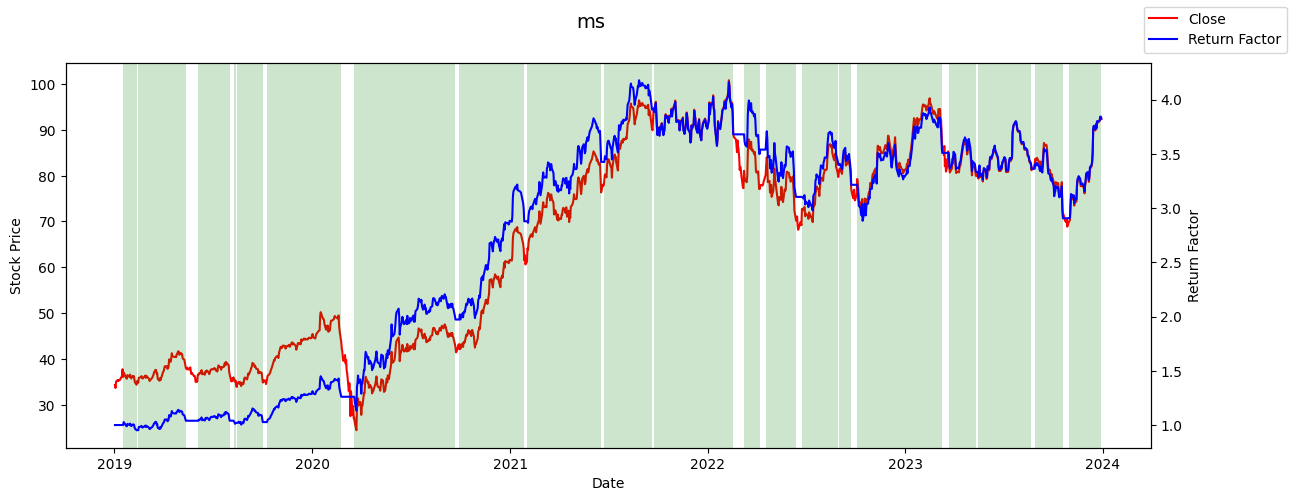

In [12]:
import matplotlib.pyplot as plt
import numpy as np


target = df.copy()
target['return_factor'] = target['value']/100
target = target.set_index('Date')


fig, ax1 = plt.subplots(figsize=(14, 5))
fig.suptitle(ticker, fontsize=14)

ax2 = ax1.twinx()

ax2.plot(target.index, target['return_factor'], '-b', label = 'Return Factor')
ax1.plot(target.index, target['Close'], '-r', label = 'Close')



for item in trades:
    plt.axvspan(item['start_date'], item['close_date'], facecolor='g', alpha=0.2)


ax1.set_ylabel("Stock Price")
ax2.set_ylabel("Return Factor")
ax1.set_xlabel("Date")
fig.legend()


### Experiment 3

In [13]:
def filter_MACD_div(data): 
    decision_list = [] 

    for index in range(len(data)): 

        if index < 10: 
            decision_list.append(0)
            continue

        window_size = 30
        window = data[max(0, index+1-window_size):index+1]

        pos = window[window>0].mean()
        neg = window[window<0].mean()

        if data[index] < neg: decision_list.append(-1)
        elif data[index] > pos: decision_list.append(1)
        else: decision_list.append(0)
    
    decision_list2 = [] 
        
    for index in range(len(decision_list)): 
        
        if index < 2: 
            decision_list2.append(0)
            continue
        
        window_size = 3
        window = decision_list[max(0, index+1-window_size): index+1]

        if sum(window) == window_size: decision_list2.append(1)
        elif sum(window) == -window_size: decision_list2.append(-1)
        else: decision_list2.append(0)
        
    return decision_list2


def filter_MACD(data): 
    decision_list = [] 

    for index in range(len(data)): 

        if index < 10: 
            decision_list.append(0)
            continue

        window_size = 30
        window = data[max(0, index+1-window_size):index+1]

        pos = window[window>0].mean()
        neg = window[window<0].mean()
        
        if data[index] < neg: decision_list.append(-1)
        elif data[index] > pos: decision_list.append(1)
        else: decision_list.append(0)
    
    decision_list2 = [] 
        
    for index in range(len(decision_list)): 
        
        if index < 2: 
            decision_list2.append(0)
            continue
        
        window_size = 3
        window = decision_list[max(0, index+1-window_size): index+1]

        if sum(window) == window_size: decision_list2.append(1)
        elif sum(window) == -window_size: decision_list2.append(-1)
        else: decision_list2.append(0)
        
    return decision_list2


def experiment3(item, candidate, vanila = 0, lag = 0, buy_threshold = 0, sell_threshold = 0, choice_action = 'macd'):
    
    short = candidate['short']
    long = candidate['long']
    signal = candidate['signal']
    buy_threshold = candidate['buy_threshold']
    sell_threshold = candidate['sell_threshold']
    
      
    # forecasted values (current day)
    results = item.copy()
    
    # obtain ema & rsi values 
    results[['ema26_1', 'ema12_1', 'macd_1', 'rsi_1']] = results.apply(lambda x: technical_indicators2(x, st = short, lt = long, vanila = vanila, lag = lag), axis = 1, result_type='expand')
    
    # ema of MACD 
    results['macd_signal_1'] = ta.ema(results['macd_1'], length = signal, adjust = False, min_periods = 1)        
    
    # filter MACD signals 
    results['filtered_MACD'] = filter_MACD(results['macd_1'])    
    
    
    # MACD Histogram 
    results['macd_div_1'] = results['macd_1'] - results['macd_signal_1']
    # filter MACD signals 
    results['filtered_MACD_div'] = filter_MACD_div(results['macd_div_1'])            
    
    
    
#     results['action'] = results['filtered_MACD']
    results['action'] = results.apply(lambda x: 1 if (x['filtered_MACD'] == 1 or x['filtered_MACD_div'] == 1) else (-1 if (x['filtered_MACD'] == -1 or x['filtered_MACD_div'] == 1) else 0), axis = 1)
#     results['action'] = results.apply(lambda x: 1 if x['macd_1'] > 0 else (-1 if x['macd_1'] < 0 else 0), axis = 1)
    
    # obtain pct_change for outcome computation 
    results['pct_change'] = results['Close'].pct_change() 

    output = results.copy()
    output = output.reset_index(drop = False)
    output = output.fillna(0)    
    output = output[['Date', 'Close', 'pct_change', 'action']]

    return output, results

In [14]:

candidate = {
    'short': 12, 
    'long': 26, 
    'signal': 9, 
    'buy_threshold': 0, 
    'sell_threshold': 0, 
}

targetData = forecasted.copy() 
output, workings_df = experiment3(targetData, candidate, vanila = 0, lag = 0)
df, trades = macdWalkthrough(output, commision = 0.0)

print(len(trades))
df

27


,Date,Close,pct_change,t_action,eff_action,value,cur_position
0,2019-01-02,34.282745,0.000000,0,0,100.000000,0
1,2019-01-03,33.671761,-0.017822,0,0,100.000000,0
2,2019-01-04,35.046455,0.040826,0,0,100.000000,0
3,2019-01-07,35.394379,0.009927,0,0,100.000000,0
4,2019-01-08,35.173748,-0.006233,0,0,100.000000,0
...,...,...,...,...,...,...,...
1253,2023-12-22,91.513542,-0.002375,1,0,245.171398,1
1254,2023-12-26,91.939362,0.004653,0,0,246.312199,1
1255,2023-12-27,92.751411,0.008832,0,0,248.487739,1
1256,2023-12-28,92.731606,-0.000214,0,0,248.434678,1


### Experiment 3 with Fees

In [15]:
candidate = {
    'short': 12, 
    'long': 26, 
    'signal': 9, 
    'buy_threshold': 0, 
    'sell_threshold': 0, 
}

targetData = vanilla.copy() 
output, workings_df = experiment1(targetData, candidate, vanila = 1, lag = 0)
df1, trades = macdWalkthrough(output, commision = specified_commision)

print(len(trades))
df1

macd_chosen
40


,Date,Close,pct_change,t_action,eff_action,value,cur_position
0,2019-01-02,34.282745,0.000000,0,0,100.000000,0
1,2019-01-03,33.671761,-0.017822,0,0,100.000000,0
2,2019-01-04,35.046455,0.040826,0,0,100.000000,0
3,2019-01-07,35.394379,0.009927,0,0,100.000000,0
4,2019-01-08,35.173748,-0.006233,0,0,100.000000,0
...,...,...,...,...,...,...,...
1253,2023-12-22,91.513542,-0.002375,1,0,218.192046,1
1254,2023-12-26,91.939362,0.004653,1,0,219.207310,1
1255,2023-12-27,92.751411,0.008832,1,0,221.143447,1
1256,2023-12-28,92.731606,-0.000214,1,0,221.096225,1


In [16]:
candidate = {
    'short': 12, 
    'long': 26, 
    'signal': 9, 
    'buy_threshold': 0, 
    'sell_threshold': 0, 
}

targetData = forecasted.copy() 
output, workings_df = experiment3(targetData, candidate, vanila = 0, lag = 0)
df, trades = macdWalkthrough(output, commision = specified_commision)

print(len(trades))
df

27


,Date,Close,pct_change,t_action,eff_action,value,cur_position
0,2019-01-02,34.282745,0.000000,0,0,100.000000,0
1,2019-01-03,33.671761,-0.017822,0,0,100.000000,0
2,2019-01-04,35.046455,0.040826,0,0,100.000000,0
3,2019-01-07,35.394379,0.009927,0,0,100.000000,0
4,2019-01-08,35.173748,-0.006233,0,0,100.000000,0
...,...,...,...,...,...,...,...
1253,2023-12-22,91.513542,-0.002375,1,0,229.445633,1
1254,2023-12-26,91.939362,0.004653,0,0,230.513261,1
1255,2023-12-27,92.751411,0.008832,0,0,232.549258,1
1256,2023-12-28,92.731606,-0.000214,0,0,232.499600,1


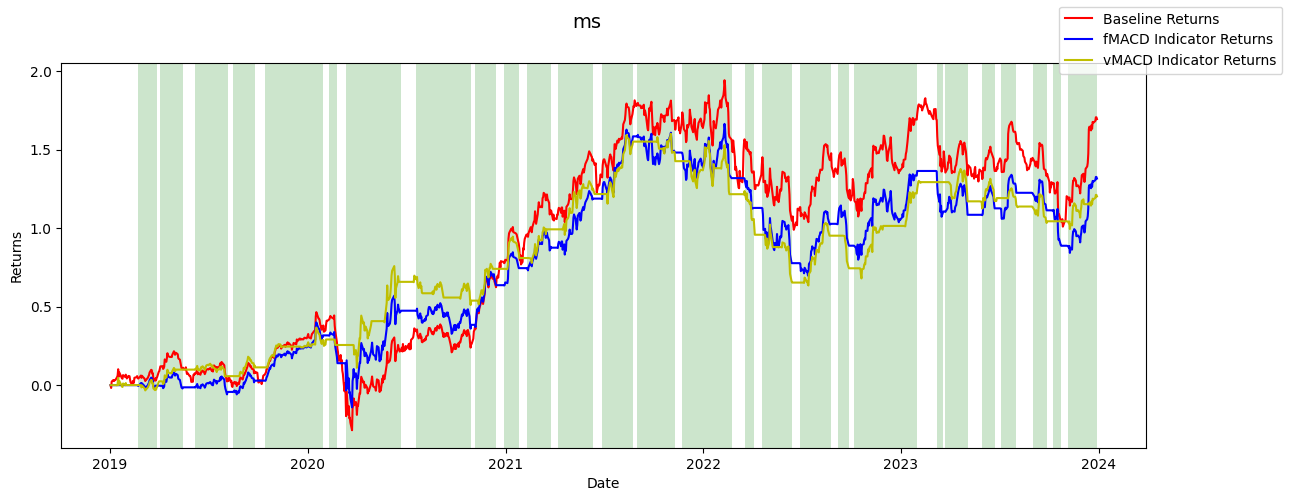

In [17]:
import matplotlib.pyplot as plt
import numpy as np


target = df.copy()
target1 = df1.copy() 

# fMACD
target['indicator_returns'] = (target['value']-100)/100

# baseline
start = target['Close'][0]
target['stock_returns'] = (target['Close'] - start)/start

# vMACD 
target1['indicator_returns'] = (target1['value']-100)/100

fig, ax1 = plt.subplots(figsize=(14, 5))
fig.suptitle(ticker, fontsize=14)

ax1.plot(target['Date'], target['stock_returns'], '-r', label = 'Baseline Returns')
ax1.plot(target['Date'], target['indicator_returns'], '-b', label = 'fMACD Indicator Returns')
ax1.plot(target['Date'], target1['indicator_returns'], '-y', label = 'vMACD Indicator Returns')



for item in trades:
    plt.axvspan(item['start_date'], item['close_date'], facecolor='g', alpha=0.2)


ax1.set_ylabel("Returns")
ax1.set_xlabel("Date")
fig.legend()

### Experiment 4

In [18]:
import pandas as pd
import pandas_ta as ta

from datetime import date, datetime
# data retrieval 
# < insert code > 


import numpy as np 

def macdWalkthroughGA(targetdf, initial_capital = 100, c_position = 0, commision = 0):
    trade_history = []

    ar_vmacd = targetdf.to_numpy() 

    target = ar_vmacd

    # 0 - date 
    # 1 - Close 
    # 2 - pct_change 
    # 3 - triggered action 
    # 4 - effective action 
    # 5 - value of investment 
    # 6 - current position 

    # states: 
#     c_position = 0 
#     initial_capital = 100
#     commision = 0.00

    column_names = ['Date', 'Close', 'pct_change', 't_action', 'eff_action', 'value', 'cur_position']

    results = [] 

    for row in range(len(target)):

        item = target[row]
        c_action = item[3]

        # identify effective action 
        if c_action == c_position: item = np.append(item, 0)
        elif c_action == 1 and c_position == 1: item = np.append(item, 0)
        elif c_action == -1 and c_position == 0: item = np.append(item, 0)
        else: item = np.append(item, c_action)


        e_action = item[4]
        if e_action == 1: 
            new_record = {'start': row, 'start_date': item[0], 'start_value': item[1], 'start_capital': results[row - 1][5]}
            trade_history.append(new_record)

            # update 
            if row != 0: item = np.append(item, results[row - 1][5]*(1-commision)) # investment value 
            else: item = np.append(item, initial_capital)
            item = np.append(item, 1) # current position 
            c_position = 1

        elif e_action == -1: 
            item = np.append(item, (results[row - 1][5]*(1+item[2]))*(1-commision))
            item = np.append(item, 0)
            c_position = 0 
            
            update_record = trade_history.pop() # take the lastest record 
            update_record['close'] = row 
            update_record['close_date'] = item[0]
            update_record['close_value'] = item[1]
            update_record['close_capital'] = item[5]
            update_record['close_capital_adj'] = update_record['start_capital'] * (1 + ((update_record['close_value'] - update_record['start_value'])/update_record['start_value']))
            trade_history.append(update_record)            

        elif e_action == 0: 
            if row != 0 :
                if c_position == 1: 
                    item = np.append(item, (results[row - 1][5] * (1+item[2]))) # investment value 
                    item = np.append(item, c_position) # current position             

                elif c_position == 0: 
    #                 print(target[row - 1])
                    item = np.append(item, results[row - 1][5]) # investment value 
                    item = np.append(item, c_position)      
            else: 
                item = np.append(item, initial_capital) # investment value 
                item = np.append(item, c_position)  

        results.append(item)
        
        if row == len(target) - 1 and c_position == 1: 
            update_record = trade_history.pop() # take the lastest record             
            update_record['close'] = row 
            update_record['close_date'] = item[0]
            update_record['close_value'] = item[1] 
            update_record['close_capital'] = item[5]     
            update_record['close_capital_adj'] = update_record['start_capital'] * (1 + ((update_record['close_value'] - update_record['start_value'])/update_record['start_value']))
            
            trade_history.append(update_record)
            
        
    result_df = pd.DataFrame(results, columns = column_names)
    return result_df, trade_history, item[5]

def retrieve_data_GA(ticker = 'xom'): 

    df = pd.read_csv(f'data_repair/{ticker}_retrived_close.csv')
    df['Date'] = df.apply(lambda x: datetime.strptime(x.Date, '%Y-%m-%d').date(), axis = 1)
    df = df.rename(columns = {'close':'Close'})
    df = df.set_index('Date')

    # perfect macd
    df1 = df.copy()[[]]
    df1['Date1'] = df1.index
    for index in range(60, 0, -1): 
        df1[f'Tm{index}_Price'] = df['Close'].shift(index)
    df1 = pd.concat([df1, df['Close']], axis = 1)
    for index in range(1, 14, 1): 
        df1[f'Tp{index}_Price'] = df['Close'].shift(-index)
    df1 = df1[df1['Date1'] >= date(2019, 1, 1)][df1['Date1'] < date(2024, 1, 1)]
    p_macd = df1.copy() 


    # normal macd
    df1 = df.copy()[[]]
    df1['Date1'] = df1.index
    for index in range(26, 0, -1): 
        df1[f'Tm{index}_Price'] = df['Close'].shift(index)    
    df1 = pd.concat([df1, df['Close']], axis = 1)
    df1 = df1[df1['Date1'] >= date(2019, 1, 1)][df1['Date1'] < date(2024, 1, 1)]
    v_macd = df1.copy() 

    # forecasted macd 
    df1 = df.copy()[[]]
    df1['Date1'] = df1.index
    for index in range(60, 0, -1): 
        df1[f'Tm{index}_Price'] = df['Close'].shift(index)
    df1 = pd.concat([df1, df['Close']], axis = 1)
    df1 = df1[df1['Date1'] >= date(2019, 1, 1)][df1['Date1'] < date(2024, 1, 1)]
    predicted = pd.read_csv(f'{ticker}/data/test/OVERALL_prediction_by_model.csv', index_col='Date')
    predicted = predicted.reset_index(drop = False)
    predicted['Date'] = predicted.apply(lambda x: datetime.strptime(x.Date, '%Y-%m-%d').date(), axis = 1)
    predicted = predicted.set_index('Date')
    predicted = predicted[[col for col in predicted.columns if 'pred' in col]]

    f_macd = pd.concat([df1, predicted], axis = 1)

    return p_macd, v_macd, f_macd

def technical_indicatorsGA(x, st, lt, vanila = 0, lag = 0): 

    # initialize lag 
    if vanila == 1: 
        lag = 0
        rsi_lag = 0 
    else: 
        rsi_lag = 7 # to achieve the usage of half predicted and half historical 

    
    # calculate ema 26
    length = lt    
    ema26 = x[-(length+lag):]
    ema26 = ta.ema(ema26, length = length, adjust = False, min_periods = 1)
    ema26 = ema26.values[-(1+lag):][0]

    # calculate ema12 
    length = st
    ema12 = x[-(length+lag):]
    ema12 = ta.ema(ema12, length = length, adjust = False, min_periods = 1)
    ema12 = ema12.values[-(1+lag):][0]    

    # calculate macd 
    macd = ema12 - ema26
    
    # calculate rsi 
    length = 15
    rsi = x[-(length+rsi_lag):]
    rsi = ta.rsi(rsi, length = 14)
    rsi = rsi.values[-(1+rsi_lag):][0]
    
    return (ema26, ema12, macd, rsi)


def filter_MACD_div(data, window_agg, window_decision): 
    decision_list = [] 

    for index in range(len(data)): 

        if index < 10: 
            decision_list.append(0)
            continue

        window_size = window_agg
        window = data[max(0, index+1-window_size):index+1]

        pos = window[window>0].mean()
        neg = window[window<0].mean()

        if data[index] < neg: decision_list.append(-1)
        elif data[index] > pos: decision_list.append(1)
        else: decision_list.append(0)
    
    decision_list2 = [] 
        
    for index in range(len(decision_list)): 
        
        if index < 2: 
            decision_list2.append(0)
            continue
        
        window_size = window_decision
        window = decision_list[max(0, index+1-window_size): index+1]

        if sum(window) == window_size: decision_list2.append(1)
        elif sum(window) == -window_size: decision_list2.append(-1)
        else: decision_list2.append(0)
        
    return decision_list2


def filter_MACD(data, window_agg, window_decision): 
    decision_list = [] 

    for index in range(len(data)): 

        if index < 10: 
            decision_list.append(0)
            continue

        window_size = window_agg
        window = data[max(0, index+1-window_size):index+1]

        pos = window[window>0].mean()
        neg = window[window<0].mean()
        
        if data[index] < neg: decision_list.append(-1)
        elif data[index] > pos: decision_list.append(1)
        else: decision_list.append(0)
    
    decision_list2 = [] 
        
    for index in range(len(decision_list)): 
        
        if index < 2: 
            decision_list2.append(0)
            continue
        
        window_size = window_decision
        window = decision_list[max(0, index+1-window_size): index+1]

        if sum(window) == window_size: decision_list2.append(1)
        elif sum(window) == -window_size: decision_list2.append(-1)
        else: decision_list2.append(0)
        
    return decision_list2


def experiment4(item, candidate, vanila = 0, lag = 0, buy_threshold = 0, sell_threshold = 0, choice_action = 'macd'):

    
    # 0 - MACD slow 
    # 1 - MACD fast 
    # 2 - signal 
    # 3 - aggregation window length 
    # 4 - aggregation decision length     
    
    short = candidate[1]
    long = candidate[0]
    signal = candidate[2]
    window_agg = candidate[3]
    window_decision = candidate[4]
      
    # forecasted values (current day)
    results = item.copy()
    
    # obtain ema & rsi values 
    results[['ema26_1', 'ema12_1', 'macd_1', 'rsi_1']] = results.apply(lambda x: technical_indicatorsGA(x, st = short, lt = long, vanila = vanila, lag = lag), axis = 1, result_type='expand')
    
    # ema of MACD 
    results['macd_signal_1'] = ta.ema(results['macd_1'], length = signal, adjust = False, min_periods = 1)        
    
    # filter MACD signals 
    results['filtered_MACD'] = filter_MACD(results['macd_1'], window_agg, window_decision)    
    
    
    # MACD Histogram 
    results['macd_div_1'] = results['macd_1'] - results['macd_signal_1']
    # filter MACD signals 
    results['filtered_MACD_div'] = filter_MACD_div(results['macd_div_1'], window_agg, window_decision)            
    
    
    
#     results['action'] = results['filtered_MACD']
    results['action'] = results.apply(lambda x: 1 if (x['filtered_MACD'] == 1 or x['filtered_MACD_div'] == 1) else (-1 if (x['filtered_MACD'] == -1 or x['filtered_MACD_div'] == 1) else 0), axis = 1)
#     results['action'] = results.apply(lambda x: 1 if x['macd_1'] > 0 else (-1 if x['macd_1'] < 0 else 0), axis = 1)
    
    # obtain pct_change for outcome computation 
    results['pct_change'] = results['Close'].pct_change() 

    output = results.copy()
    output = output.reset_index(drop = False)
    output = output.fillna(0)    
    output = output[['Date', 'Close', 'pct_change', 'action']]

    return output, results


def tradeFitnessFunction(df, candidate): 
    
    target, workings_df = experiment4(df, candidate, vanila = 0, lag = 0, buy_threshold = 0, sell_threshold = 0)
    df, trades, value = macdWalkthroughGA(target, commision = specified_commision)
    
    return value, df, trades

# limit dataframe 
ticker = 'ms'
perfect, vanilla, forecasted = retrieve_data_GA(ticker)

data = forecasted.head(600).copy() 
data

/tmp/ipykernel_18429/1131844419.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df1[df1['Date1'] >= date(2019, 1, 1)][df1['Date1'] < date(2024, 1, 1)]
/tmp/ipykernel_18429/1131844419.py:126: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df1[df1['Date1'] >= date(2019, 1, 1)][df1['Date1'] < date(2024, 1, 1)]
/tmp/ipykernel_18429/1131844419.py:135: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df1[df1['Date1'] >= date(2019, 1, 1)][df1['Date1'] < date(2024, 1, 1)]


,Date1,Tm60_Price,Tm59_Price,Tm58_Price,Tm57_Price,Tm56_Price,Tm55_Price,Tm54_Price,Tm53_Price,Tm52_Price,...,Tp4_pred,Tp5_pred,Tp6_pred,Tp7_pred,Tp8_pred,Tp9_pred,Tp10_pred,Tp11_pred,Tp12_pred,Tp13_pred
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,2019-01-02,39.838696,39.400448,39.627998,38.903206,37.605297,36.652946,36.602386,36.636089,38.717781,...,34.046500,34.483080,34.061176,33.549478,33.671867,34.718180,34.530071,34.396459,34.231987,34.628927
2019-01-03,2019-01-03,39.400448,39.627998,38.903206,37.605297,36.652946,36.602386,36.636089,38.717781,39.771267,...,34.571734,34.598526,34.547172,34.710308,34.428320,34.967014,34.712110,34.928092,35.146004,34.629495
2019-01-04,2019-01-04,39.627998,38.903206,37.605297,36.652946,36.602386,36.636089,38.717781,39.771267,38.793629,...,33.996786,34.549978,34.073036,34.048130,33.803326,34.599107,34.155066,34.701574,34.603372,34.674837
2019-01-07,2019-01-07,38.903206,37.605297,36.652946,36.602386,36.636089,38.717781,39.771267,38.793629,39.122330,...,34.853754,33.948058,34.529240,34.587153,35.212146,35.131816,35.080180,34.842242,35.097906,34.746894
2019-01-08,2019-01-08,37.605297,36.652946,36.602386,36.636089,38.717781,39.771267,38.793629,39.122330,38.018265,...,34.617323,34.670303,35.081187,34.850008,34.527064,34.999579,34.530120,34.598188,34.815246,34.655145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-13,2021-05-13,68.216003,67.655457,68.713272,69.979042,70.069458,72.221275,70.910286,69.499870,71.570312,...,75.542363,74.400819,76.055257,75.040997,75.827138,76.738503,75.934157,75.795362,76.613668,75.797160
2021-05-14,2021-05-14,67.655457,68.713272,69.979042,70.069458,72.221275,70.910286,69.499870,71.570312,73.044022,...,76.419737,74.588859,75.512586,75.739818,77.126180,77.527340,76.298568,76.692071,77.487511,76.117862
2021-05-17,2021-05-17,68.713272,69.979042,70.069458,72.221275,70.910286,69.499870,71.570312,73.044022,74.192245,...,77.525602,76.191381,78.600950,76.939408,76.697567,79.065832,76.943452,78.101271,77.992222,77.141623


In [ ]:
import numpy as np 
import random 
from tqdm.auto import tqdm 
import math, copy

df = data

long_range = [num for num in range(10, 61) if num%2 == 0] # limited by prediction timeframe 
short_range = [num for num in range(2, 31) if num%2 == 0] # limited by prediction timeframe 
signals = [num for num in range(5, 31) if num%2 == 1] # not limited
window_agg = [10, 15, 20, 25, 30]
window_decision = [1, 2, 3, 4, 5]

# initialize population 

population = [] 

for lr in long_range: 
    for sr in short_range: 
        if lr > sr: 
            for instance_signal in signals: 
                for window1 in window_agg: 
                    for window2 in window_decision: 
                        instance = {} 
                        instance[0] = lr # long range 
                        instance[1] = sr # short range 
                        instance[2] = instance_signal # signal 
                        instance[3] = window1 # rsi period  
                        instance[4] = window2
                        
                        population.append(instance)

                        
# 0 - MACD long 
# 1 - MACD short 
# 2 - signal
# 3 - RSI period 
# 4 - RSI threshold 
                        
# configuration 
crossover_rate = 0.8
mutation_rate = 0.25

# identify a generation 
gen_size = 20
generation = random.sample(population, gen_size)

# mating pool 
mating_prop = 0.75
eliteism_prop = 0.1


parent_size = int(mating_prop * gen_size)
elitism_size = 1
crossover_size = gen_size - elitism_size 

count = 0
threshold = 100

visited = [] 


for index in tqdm(range(threshold + 1)):
    # mating 
    candidate_pool = [] 
    fitness_values = [] 
    trades = []

    for candidate in tqdm(generation): 
        fitness, df1_output, trade = tradeFitnessFunction(df, candidate)
        print(f'{candidate}: {fitness}')
        candidate_pool.append(candidate)
        fitness_values.append(fitness)
        trades.append(len(trade))
        visited.append(candidate)
    
    trades[2] = 0
    
    candidates = {'candidates': candidate_pool, 'fitness': fitness_values, 'trades': trades}
    
    candidates = pd.DataFrame(candidates).sort_values(by=['fitness'], ascending = False)
#     print(candidates)
    candidates = candidates[candidates['trades'] > 0]
    print(candidates)
    print('=================================================')
    if index == threshold: break     

    # select elite candidate 
    
    elitism = list(candidates.head(elitism_size)['candidates'])
    elitism = copy.deepcopy(elitism[0])
    
    # select top to be part of mating pool 
    candidates = list(candidates.head(parent_size)['candidates'])#[1:]
        
    # new generation 
    generation = [elitism] 

    # eliteism 
#     print(f"Elite1: {elitism}")
#     generation += elitism
    
    # crossover
    crossover_batch = [] 
#     crossover_batch += elitism
    
    for index in range(math.ceil(crossover_size/2)): 
        
        # pick 2 parent for crossover 
        instance = random.sample(candidates, 2)
               
        # from 0 - 4 select 1-2 elements for crossover (why 1 - 2? cross over effect is the same)
        instance_run = set([random.randint(0, 4) for index in range(random.randint(1, 2))]) # max is half swapped 
        
        # perform crossover 
        for item in instance_run: 
            store = instance[0][item]
            instance[0][item] = instance[1][item]
            instance[1][item] = store 

            
        
        # check for validity of crossover
        for child in range(len(instance)): 
            if instance[child][0] < instance[child][1]: # long term < short term 
                store = instance[child][0]
                instance[child][0] = instance[child][1]
                instance[child][1] = instance[child][0]
            elif instance[child][0] == instance[child][1]: # if equal just add by a constant 
                instance[child][0] = instance[child][0] + 14
                
        # append both crossed descendents 
        crossover_batch += instance
    
    
    crossover_batch = crossover_batch[:crossover_size]     
        
    
    # mutation - select one element for mutation 
    for index in range(len(crossover_batch)): 
        
        gene = random.randint(0, 4)
        
        if gene == 0: 
            while True: 
                selected = random.sample(long_range, 1)[0]
                
                if selected == crossover_batch[index][1]: continue # same as short run 
                elif selected < crossover_batch[index][1]: 
                    crossover_batch[index][gene] = crossover_batch[index][1]
                    crossover_batch[index][1] = selected 
                else: 
                    crossover_batch[index][gene] = selected 
                break
        elif gene == 1: 
            while True: 
                selected = random.sample(short_range, 1)[0]
                
                if selected == crossover_batch[index][0]: continue # same as long run 
                elif selected > crossover_batch[index][0]: 
                    crossover_batch[index][gene] = crossover_batch[index][0]
                    crossover_batch[index][0] = selected 
                else: 
                    crossover_batch[index][gene] = selected 
                break            
        elif gene == 2:
            selected = random.sample(signals, 1)[0]
            crossover_batch[index][gene] = selected 
        elif gene == 3: 
            selected = random.sample(window_agg, 1)[0]
            crossover_batch[index][gene] = selected 
        elif gene == 4: 
            selected = random.sample(window_decision, 1)[0]
            crossover_batch[index][gene] = selected 
        
#     print(f"Elite2: {elitism}")
    
    cross2 = [] 
    
    for index in range(len(crossover_batch)):
        
#         print(type(crossover_batch[index]), type(elitism))
        
        item = crossover_batch[index]
        
        while crossover_batch[index] == elitism: 
            print(f'elite_in: {crossover_batch[index]}')                   
            crossover_batch[index] = random.sample(population, 1)[0]
            print(f'elite_out: {crossover_batch[index]}')             
        
        if item not in cross2: 
            cross2.append(item)
        else: 
            while item in cross2 or item in visited: 
                item = random.sample(population, 1)[0]
            cross2.append(item)       
        
    
#     print(f'elite: {generation}')       
#     print(f'rest: {crossover_batch}')
    generation += cross2
#     print(f'total: {generation}')
#     break

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 16, 1: 10, 2: 15, 3: 20, 4: 2}: 110.73815926251282
{0: 26, 1: 24, 2: 9, 3: 10, 4: 3}: 176.8503402483623
{0: 26, 1: 18, 2: 19, 3: 15, 4: 4}: 240.0043285662102
{0: 50, 1: 8, 2: 19, 3: 15, 4: 2}: 231.59471820628136
{0: 18, 1: 8, 2: 29, 3: 15, 4: 1}: 126.15468074771613
{0: 40, 1: 12, 2: 21, 3: 20, 4: 3}: 166.5132553112333
{0: 40, 1: 12, 2: 21, 3: 10, 4: 5}: 189.73352651185854
{0: 30, 1: 14, 2: 27, 3: 20, 4: 1}: 232.7174742618538
{0: 60, 1: 2, 2: 27, 3: 15, 4: 3}: 212.14039267842284
{0: 14, 1: 4, 2: 5, 3: 30, 4: 3}: 156.71373666237804
{0: 28, 1: 12, 2: 11, 3: 25, 4: 4}: 281.4569889646093
{0: 42, 1: 8, 2: 27, 3: 30, 4: 2}: 221.25975616001872
{0: 42, 1: 14, 2: 13, 3: 25, 4: 3}: 185.61016515758865
{0: 44, 1: 12, 2: 5, 3: 30, 4: 1}: 276.4188914251858
{0: 40, 1: 18, 2: 15, 3: 25, 4: 4}: 216.71811760291354
{0: 60, 1: 6, 2: 9, 3: 30, 4: 1}: 214.47435267113974
{0: 30, 1: 6, 2: 29, 3: 10, 4: 2}: 200.42123908173195
{0: 32, 1: 2, 2: 13, 3: 25, 4: 4}: 258.61863131164745
{0: 32, 1: 2, 2: 25, 3: 25, 

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 28, 1: 12, 2: 11, 3: 25, 4: 4}: 281.4569889646093
{0: 46, 1: 8, 2: 15, 3: 25, 4: 1}: 226.73909340861155
{0: 30, 1: 14, 2: 11, 3: 30, 4: 1}: 258.1642862296166
{0: 26, 1: 4, 2: 5, 3: 10, 4: 3}: 253.32907570163945
{0: 44, 1: 12, 2: 19, 3: 10, 4: 2}: 247.41634681609264
{0: 38, 1: 4, 2: 7, 3: 30, 4: 4}: 208.28780280650784
{0: 48, 1: 4, 2: 17, 3: 30, 4: 3}: 197.82113062624418
{0: 52, 1: 2, 2: 25, 3: 25, 4: 4}: 200.71596523010112
{0: 32, 1: 4, 2: 13, 3: 20, 4: 1}: 205.46123975675096
{0: 50, 1: 8, 2: 7, 3: 10, 4: 5}: 182.0697625287094
{0: 30, 1: 22, 2: 23, 3: 15, 4: 5}: 243.0612810512626
{0: 50, 1: 8, 2: 19, 3: 15, 4: 5}: 206.75669917374165
{0: 40, 1: 10, 2: 23, 3: 20, 4: 4}: 195.0957881677537
{0: 48, 1: 16, 2: 25, 3: 30, 4: 1}: 223.123351037552
{0: 58, 1: 12, 2: 11, 3: 25, 4: 5}: 196.96411776238648
{0: 60, 1: 12, 2: 21, 3: 15, 4: 3}: 188.30952195806054
{0: 20, 1: 12, 2: 19, 3: 20, 4: 2}: 203.83052876795614
{0: 60, 1: 20, 2: 9, 3: 25, 4: 4}: 220.64361666457978
{0: 36, 1: 14, 2: 19, 3: 25, 

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 28, 1: 12, 2: 11, 3: 25, 4: 4}: 281.4569889646093
{0: 20, 1: 2, 2: 25, 3: 25, 4: 4}: 229.48186785740697
{0: 30, 1: 22, 2: 19, 3: 25, 4: 5}: 227.38908680139664
{0: 42, 1: 26, 2: 29, 3: 25, 4: 1}: 199.18405100421853
{0: 44, 1: 16, 2: 27, 3: 30, 4: 2}: 228.07530305643763
{0: 34, 1: 4, 2: 17, 3: 20, 4: 3}: 213.04620667397296
{0: 56, 1: 20, 2: 13, 3: 30, 4: 5}: 203.92451708080594
{0: 58, 1: 12, 2: 11, 3: 25, 4: 4}: 187.37595554366894
{0: 28, 1: 12, 2: 15, 3: 25, 4: 4}: 281.4569889646093
{0: 32, 1: 4, 2: 9, 3: 20, 4: 5}: 199.97310982498334
{0: 32, 1: 4, 2: 25, 3: 20, 4: 3}: 258.03033471492404
{0: 38, 1: 30, 2: 25, 3: 25, 4: 5}: 169.15404823675584
{0: 36, 1: 12, 2: 25, 3: 15, 4: 3}: 190.1042493306229
{0: 36, 1: 12, 2: 15, 3: 20, 4: 4}: 212.92420803695387
{0: 48, 1: 16, 2: 25, 3: 20, 4: 1}: 248.98889505771368
{0: 36, 1: 28, 2: 17, 3: 15, 4: 4}: 202.92714202674543
{0: 52, 1: 14, 2: 23, 3: 15, 4: 1}: 212.40914329435128
{0: 38, 1: 8, 2: 17, 3: 25, 4: 1}: 262.27222107152875
{0: 38, 1: 4, 2: 7,

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 28, 1: 12, 2: 11, 3: 25, 4: 4}: 281.4569889646093
{0: 36, 1: 20, 2: 9, 3: 25, 4: 4}: 208.959017767057
{0: 28, 1: 6, 2: 11, 3: 15, 4: 2}: 222.16766790810166
{0: 34, 1: 4, 2: 17, 3: 30, 4: 4}: 264.26285714209774
{0: 52, 1: 4, 2: 23, 3: 20, 4: 1}: 205.4778204501309
{0: 36, 1: 12, 2: 11, 3: 10, 4: 4}: 194.82069257366837
{0: 20, 1: 2, 2: 25, 3: 25, 4: 4}: 229.48186785740697
{0: 28, 1: 12, 2: 11, 3: 15, 4: 4}: 275.0808514086974
{0: 44, 1: 12, 2: 19, 3: 20, 4: 1}: 243.10210291057794
{0: 46, 1: 14, 2: 23, 3: 20, 4: 1}: 231.01069499252318
{0: 52, 1: 22, 2: 25, 3: 15, 4: 4}: 205.13010772847298
{0: 58, 1: 4, 2: 5, 3: 10, 4: 2}: 203.94222118743298
{0: 32, 1: 8, 2: 5, 3: 20, 4: 5}: 261.5232342453375
{0: 38, 1: 12, 2: 29, 3: 20, 4: 4}: 197.48501192189482
{0: 16, 1: 2, 2: 27, 3: 10, 4: 1}: 132.97719828694412
{0: 60, 1: 20, 2: 7, 3: 20, 4: 3}: 213.98536797212313
{0: 12, 1: 4, 2: 7, 3: 25, 4: 3}: 222.4013849975897
{0: 28, 1: 26, 2: 29, 3: 25, 4: 5}: 202.44812886208848
{0: 36, 1: 18, 2: 25, 3: 30, 4

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 28, 1: 12, 2: 11, 3: 25, 4: 4}: 281.4569889646093
{0: 60, 1: 12, 2: 23, 3: 15, 4: 1}: 175.0999733135522
{0: 58, 1: 8, 2: 11, 3: 25, 4: 4}: 186.8408960947284
{0: 36, 1: 12, 2: 25, 3: 20, 4: 5}: 177.7466848413712
{0: 28, 1: 2, 2: 11, 3: 25, 4: 4}: 212.7164352953088
{0: 22, 1: 2, 2: 7, 3: 15, 4: 3}: 180.57421551574154
{0: 44, 1: 14, 2: 13, 3: 15, 4: 2}: 275.51797041751416
{0: 54, 1: 20, 2: 29, 3: 25, 4: 4}: 205.98145014332957
{0: 28, 1: 20, 2: 17, 3: 25, 4: 5}: 220.77133136796982
{0: 48, 1: 20, 2: 7, 3: 20, 4: 5}: 226.32501119827018
{0: 52, 1: 4, 2: 13, 3: 20, 4: 3}: 200.91494837566685
{0: 36, 1: 2, 2: 19, 3: 25, 4: 4}: 242.26936921271488
{0: 24, 1: 20, 2: 25, 3: 30, 4: 4}: 212.7892704052259
{0: 32, 1: 8, 2: 25, 3: 20, 4: 4}: 229.71645122193524
{0: 46, 1: 16, 2: 15, 3: 30, 4: 5}: 209.42611248715644
{0: 38, 1: 28, 2: 23, 3: 25, 4: 2}: 218.004927936684
{0: 36, 1: 6, 2: 13, 3: 10, 4: 4}: 200.50617752628318
{0: 22, 1: 6, 2: 5, 3: 10, 4: 5}: 197.60454047616358
{0: 60, 1: 10, 2: 23, 3: 30, 

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 28, 1: 12, 2: 11, 3: 25, 4: 4}: 281.4569889646093
{0: 48, 1: 16, 2: 23, 3: 25, 4: 1}: 227.5350024463483
{0: 22, 1: 8, 2: 29, 3: 10, 4: 2}: 236.9858051229715
{0: 60, 1: 14, 2: 11, 3: 15, 4: 3}: 180.45934684719987
{0: 10, 1: 4, 2: 7, 3: 20, 4: 4}: 220.79711678936658
{0: 14, 1: 2, 2: 19, 3: 30, 4: 4}: 169.17650490132237
{0: 24, 1: 16, 2: 15, 3: 25, 4: 5}: 229.98486660524466
{0: 16, 1: 4, 2: 7, 3: 25, 4: 3}: 127.129699936484
{0: 28, 1: 20, 2: 17, 3: 15, 4: 3}: 202.4627007443696
{0: 24, 1: 16, 2: 29, 3: 30, 4: 2}: 246.37520181958874
{0: 28, 1: 10, 2: 23, 3: 20, 4: 4}: 265.94815782275145
{0: 12, 1: 4, 2: 13, 3: 25, 4: 2}: 193.24469008766445
{0: 42, 1: 2, 2: 11, 3: 25, 4: 4}: 216.31835262953456
{0: 32, 1: 18, 2: 17, 3: 25, 4: 3}: 220.48884600570872
{0: 54, 1: 20, 2: 13, 3: 10, 4: 4}: 223.545858231006
{0: 12, 1: 4, 2: 17, 3: 25, 4: 4}: 231.14695619035786
{0: 38, 1: 12, 2: 11, 3: 15, 4: 4}: 204.12447291904016
{0: 40, 1: 22, 2: 21, 3: 25, 4: 3}: 197.22118661710988
{0: 48, 1: 22, 2: 13, 3: 20

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 28, 1: 12, 2: 11, 3: 25, 4: 4}: 281.4569889646093
{0: 12, 1: 2, 2: 23, 3: 30, 4: 1}: 141.93758984392537
{0: 28, 1: 20, 2: 13, 3: 15, 4: 2}: 190.39395241028254
{0: 52, 1: 12, 2: 17, 3: 25, 4: 3}: 198.97391042532823
{0: 32, 1: 2, 2: 25, 3: 20, 4: 4}: 268.75799040248506
{0: 22, 1: 18, 2: 15, 3: 25, 4: 5}: 203.60232763396652
{0: 52, 1: 12, 2: 21, 3: 25, 4: 3}: 187.12222479893643
{0: 36, 1: 12, 2: 23, 3: 10, 4: 4}: 189.71813651885086
{0: 38, 1: 12, 2: 29, 3: 25, 4: 4}: 169.1655167677277
{0: 54, 1: 16, 2: 19, 3: 10, 4: 4}: 172.00247879334142
{0: 26, 1: 18, 2: 21, 3: 25, 4: 5}: 222.6777854106597
{0: 60, 1: 10, 2: 13, 3: 25, 4: 1}: 205.57556574829505
{0: 28, 1: 16, 2: 23, 3: 30, 4: 4}: 236.72660490983867
{0: 46, 1: 20, 2: 25, 3: 25, 4: 3}: 189.96103693455478
{0: 50, 1: 10, 2: 17, 3: 10, 4: 2}: 232.17613296133948
{0: 36, 1: 6, 2: 17, 3: 20, 4: 4}: 197.81947990112593
{0: 10, 1: 6, 2: 13, 3: 30, 4: 5}: 201.19045880548336
{0: 24, 1: 10, 2: 11, 3: 25, 4: 4}: 109.65471885292676
{0: 52, 1: 26, 2:

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 28, 1: 12, 2: 11, 3: 25, 4: 4}: 281.4569889646093
{0: 24, 1: 18, 2: 21, 3: 20, 4: 5}: 179.16069036156327
{0: 28, 1: 6, 2: 13, 3: 25, 4: 4}: 255.0280674466003
{0: 48, 1: 10, 2: 27, 3: 30, 4: 1}: 224.9873722278139
{0: 36, 1: 6, 2: 17, 3: 25, 4: 5}: 220.59481297165456
{0: 32, 1: 6, 2: 13, 3: 10, 4: 1}: 276.3850985239031
{0: 26, 1: 26, 2: 17, 3: 30, 4: 4}: 100
{0: 60, 1: 16, 2: 23, 3: 30, 4: 5}: 206.19911897004224
{0: 16, 1: 12, 2: 11, 3: 10, 4: 1}: 119.43235852940951
{0: 34, 1: 12, 2: 11, 3: 25, 4: 3}: 293.67944562004755
{0: 30, 1: 12, 2: 21, 3: 25, 4: 3}: 320.52108930619096
{0: 40, 1: 18, 2: 11, 3: 25, 4: 2}: 220.29482614194202
{0: 26, 1: 10, 2: 13, 3: 10, 4: 3}: 227.13540894117912
{0: 40, 1: 22, 2: 7, 3: 15, 4: 2}: 245.81091695210122
{0: 50, 1: 2, 2: 25, 3: 15, 4: 3}: 219.96031987293355
{0: 28, 1: 18, 2: 15, 3: 25, 4: 5}: 245.03644435857439
{0: 46, 1: 24, 2: 27, 3: 20, 4: 1}: 217.78670246649952
{0: 42, 1: 16, 2: 23, 3: 10, 4: 4}: 217.4631044120872
{0: 54, 1: 12, 2: 17, 3: 20, 4: 2}:

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 30, 1: 12, 2: 21, 3: 25, 4: 3}: 320.52108930619096
{0: 32, 1: 10, 2: 13, 3: 10, 4: 2}: 269.96086889687314
{0: 42, 1: 6, 2: 27, 3: 30, 4: 1}: 209.8079562553251
{0: 34, 1: 2, 2: 19, 3: 10, 4: 4}: 248.57326074318664
{0: 50, 1: 18, 2: 7, 3: 10, 4: 4}: 201.88312455279362
{0: 18, 1: 14, 2: 25, 3: 15, 4: 5}: 187.6195636974884
{0: 40, 1: 16, 2: 23, 3: 30, 4: 3}: 200.39676772071897
{0: 28, 1: 22, 2: 7, 3: 15, 4: 2}: 242.66544979647387
{0: 24, 1: 4, 2: 27, 3: 10, 4: 1}: 196.15190174485858
{0: 54, 1: 16, 2: 13, 3: 25, 4: 3}: 187.50949518070547
{0: 16, 1: 12, 2: 29, 3: 25, 4: 5}: 139.76360827617518
{0: 52, 1: 2, 2: 11, 3: 20, 4: 1}: 197.3131361032954
{0: 50, 1: 22, 2: 11, 3: 25, 4: 2}: 221.01500525716074
{0: 28, 1: 12, 2: 5, 3: 25, 4: 5}: 239.86198104053895
{0: 36, 1: 6, 2: 21, 3: 25, 4: 4}: 225.21230314619265
{0: 46, 1: 8, 2: 25, 3: 20, 4: 3}: 193.0832123454047
{0: 56, 1: 20, 2: 5, 3: 10, 4: 2}: 240.75780437607574
{0: 50, 1: 6, 2: 27, 3: 20, 4: 1}: 216.1432933520602
{0: 50, 1: 24, 2: 25, 3: 1

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 30, 1: 12, 2: 21, 3: 25, 4: 3}: 320.52108930619096
{0: 34, 1: 6, 2: 19, 3: 10, 4: 4}: 230.57549537814077
{0: 50, 1: 16, 2: 19, 3: 20, 4: 3}: 174.38977861174595
{0: 32, 1: 4, 2: 13, 3: 25, 4: 2}: 243.08734536450825
{0: 28, 1: 12, 2: 5, 3: 10, 4: 4}: 264.6251827094013
{0: 54, 1: 18, 2: 7, 3: 15, 4: 3}: 221.82015744584953
{0: 40, 1: 30, 2: 19, 3: 15, 4: 1}: 171.89532325760175
{0: 24, 1: 2, 2: 19, 3: 10, 4: 1}: 227.7987075062686
{0: 28, 1: 24, 2: 7, 3: 20, 4: 5}: 227.93321447151345
{0: 58, 1: 14, 2: 11, 3: 30, 4: 4}: 186.53396295763375
{0: 50, 1: 22, 2: 19, 3: 25, 4: 2}: 192.11985711795396
{0: 34, 1: 22, 2: 27, 3: 10, 4: 1}: 190.4141483357035
{0: 40, 1: 16, 2: 23, 3: 15, 4: 3}: 202.39553271936092
{0: 46, 1: 28, 2: 9, 3: 25, 4: 3}: 177.01895443025055
{0: 28, 1: 22, 2: 25, 3: 15, 4: 2}: 194.58632211722215
{0: 30, 1: 8, 2: 7, 3: 15, 4: 2}: 238.74930426916322
{0: 52, 1: 16, 2: 5, 3: 25, 4: 4}: 187.38864962602386
{0: 36, 1: 14, 2: 21, 3: 25, 4: 4}: 171.8956209580114
{0: 36, 1: 16, 2: 21, 3:

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 30, 1: 12, 2: 21, 3: 25, 4: 3}: 320.52108930619096
{0: 52, 1: 12, 2: 21, 3: 25, 4: 4}: 191.67019164270027
{0: 14, 1: 10, 2: 17, 3: 15, 4: 3}: 151.91483947431385
{0: 60, 1: 16, 2: 27, 3: 30, 4: 5}: 187.90007887599526
{0: 30, 1: 18, 2: 7, 3: 15, 4: 2}: 257.6258046340276
{0: 58, 1: 16, 2: 13, 3: 30, 4: 4}: 188.85293185586755
{0: 22, 1: 18, 2: 11, 3: 15, 4: 5}: 197.15661495431277
{0: 40, 1: 14, 2: 19, 3: 15, 4: 3}: 188.10855887613573
{0: 48, 1: 10, 2: 15, 3: 20, 4: 5}: 200.21164867148173
{0: 44, 1: 20, 2: 23, 3: 10, 4: 3}: 192.24031829334365
{0: 46, 1: 24, 2: 21, 3: 15, 4: 3}: 188.33519147421399
{0: 56, 1: 10, 2: 27, 3: 15, 4: 5}: 179.5358818496461
{0: 52, 1: 20, 2: 17, 3: 30, 4: 2}: 230.8012499531018
{0: 60, 1: 12, 2: 5, 3: 10, 4: 4}: 186.2559819881109
{0: 22, 1: 2, 2: 19, 3: 10, 4: 1}: 188.38027160754893
{0: 28, 1: 12, 2: 23, 3: 25, 4: 2}: 207.5020536191779
{0: 50, 1: 4, 2: 23, 3: 25, 4: 2}: 197.567708205106
{0: 14, 1: 10, 2: 13, 3: 10, 4: 2}: 131.1534027435122
{0: 18, 1: 6, 2: 15, 3

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 30, 1: 12, 2: 21, 3: 25, 4: 3}: 320.52108930619096
{0: 24, 1: 12, 2: 13, 3: 30, 4: 2}: 245.07358348676186
{0: 58, 1: 16, 2: 21, 3: 30, 4: 3}: 183.36031951494286
{0: 30, 1: 10, 2: 7, 3: 25, 4: 4}: 321.9635669516873
{0: 60, 1: 18, 2: 21, 3: 15, 4: 4}: 200.3845797547937
{0: 28, 1: 12, 2: 29, 3: 25, 4: 2}: 233.3517380601418
{0: 48, 1: 20, 2: 23, 3: 15, 4: 4}: 187.58907028112787
{0: 44, 1: 20, 2: 17, 3: 30, 4: 5}: 271.72674475544744
{0: 24, 1: 10, 2: 17, 3: 25, 4: 4}: 107.3593410726066
{0: 30, 1: 16, 2: 11, 3: 20, 4: 2}: 209.38407656816798
{0: 52, 1: 12, 2: 7, 3: 10, 4: 4}: 182.49728127259968
{0: 46, 1: 18, 2: 29, 3: 15, 4: 3}: 194.82013832044407
{0: 46, 1: 12, 2: 15, 3: 10, 4: 5}: 206.32502865170036
{0: 42, 1: 26, 2: 21, 3: 15, 4: 5}: 169.58996699718026
{0: 22, 1: 2, 2: 19, 3: 25, 4: 5}: 199.44066898695365
{0: 60, 1: 16, 2: 17, 3: 10, 4: 5}: 199.36795283259843
{0: 50, 1: 4, 2: 25, 3: 25, 4: 5}: 213.0765072642357
{0: 46, 1: 14, 2: 19, 3: 25, 4: 4}: 187.2989081731418
{0: 46, 1: 24, 2: 21

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 30, 1: 10, 2: 7, 3: 25, 4: 4}: 321.9635669516873
{0: 30, 1: 8, 2: 25, 3: 25, 4: 5}: 269.1587910799816
{0: 24, 1: 22, 2: 13, 3: 25, 4: 4}: 206.04075874992
{0: 34, 1: 30, 2: 21, 3: 25, 4: 1}: 257.48297969562884
{0: 48, 1: 20, 2: 23, 3: 30, 4: 5}: 199.68878072747046
{0: 30, 1: 10, 2: 21, 3: 10, 4: 2}: 260.1940229149142
{0: 40, 1: 22, 2: 5, 3: 20, 4: 1}: 259.03370926891597
{0: 32, 1: 8, 2: 7, 3: 30, 4: 2}: 264.4988343344732
{0: 46, 1: 10, 2: 29, 3: 15, 4: 3}: 205.33331469823705
{0: 50, 1: 20, 2: 13, 3: 30, 4: 4}: 226.6690766228692
{0: 10, 1: 2, 2: 9, 3: 30, 4: 3}: 182.71750083167063
{0: 30, 1: 2, 2: 17, 3: 20, 4: 2}: 226.84790317405805
{0: 30, 1: 22, 2: 19, 3: 10, 4: 5}: 212.55455139232913
{0: 52, 1: 16, 2: 29, 3: 15, 4: 2}: 198.8353427243108
{0: 28, 1: 12, 2: 5, 3: 25, 4: 2}: 223.40553890026587
{0: 46, 1: 14, 2: 19, 3: 20, 4: 2}: 223.64778776002663
{0: 54, 1: 18, 2: 15, 3: 30, 4: 1}: 184.6082966697175
{0: 16, 1: 4, 2: 9, 3: 25, 4: 5}: 213.06022925851556
{0: 20, 1: 6, 2: 27, 3: 10, 4: 

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 21, 3: 20, 4: 3}: 331.5461197714603
{0: 28, 1: 24, 2: 25, 3: 25, 4: 3}: 191.02251053501232
{0: 18, 1: 12, 2: 5, 3: 20, 4: 2}: 163.71494464394485
{0: 50, 1: 14, 2: 21, 3: 15, 4: 2}: 228.01497883981142
{0: 36, 1: 20, 2: 17, 3: 30, 4: 5}: 199.87617319641538
{0: 52, 1: 4, 2: 23, 3: 15, 4: 2}: 190.02223524277346
{0: 30, 1: 4, 2: 19, 3: 10, 4: 3}: 241.5372783883339
{0: 44, 1: 30, 2: 11, 3: 10, 4: 4}: 187.0340313940785
{0: 48, 1: 20, 2: 5, 3: 25, 4: 5}: 222.42936626286533
{0: 16, 1: 2, 2: 27, 3: 10, 4: 3}: 208.08884303552696
{0: 16, 1: 4, 2: 9, 3: 10, 4: 1}: 162.63728554158578
{0: 34, 1: 24, 2: 25, 3: 15, 4: 2}: 217.26606646053162
{0: 46, 1: 8, 2: 23, 3: 25, 4: 4}: 189.1833108577621
{0: 30, 1: 22, 2: 13, 3: 30, 4: 5}: 226.93018646698542
{0: 14, 1: 4, 2: 19, 3: 15, 4: 2}: 135.25786498334332
{0: 46, 1: 2, 2: 29, 3: 15, 4: 3}: 211.41263110483573
{0: 46, 1: 10, 2: 19, 3: 25, 4: 4}: 186.86182148423805
{0: 34, 1: 14, 2: 25, 3: 25, 4: 4}: 184.28979239701215
{0: 58, 1: 22, 2: 19, 3:

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 21, 3: 20, 4: 3}: 331.5461197714603
{0: 30, 1: 28, 2: 23, 3: 30, 4: 5}: 155.6473847836744
{0: 14, 1: 8, 2: 17, 3: 25, 4: 3}: 213.35434415311624
{0: 24, 1: 14, 2: 17, 3: 25, 4: 1}: 293.85554000517305
{0: 42, 1: 12, 2: 5, 3: 20, 4: 3}: 211.17574907716664
{0: 44, 1: 14, 2: 11, 3: 10, 4: 2}: 260.4576643755599
{0: 52, 1: 4, 2: 5, 3: 15, 4: 4}: 193.88265550643894
{0: 38, 1: 2, 2: 25, 3: 25, 4: 3}: 203.2018432594004
{0: 50, 1: 24, 2: 21, 3: 15, 4: 2}: 196.43759745139184
{0: 20, 1: 16, 2: 25, 3: 30, 4: 2}: 210.35691009485373
{0: 46, 1: 24, 2: 19, 3: 15, 4: 4}: 206.155046470477
{0: 48, 1: 20, 2: 21, 3: 25, 4: 2}: 219.92520959457656
{0: 44, 1: 20, 2: 9, 3: 10, 4: 4}: 236.62139996997885
{0: 44, 1: 18, 2: 17, 3: 25, 4: 3}: 224.46233762450532
{0: 14, 1: 10, 2: 25, 3: 15, 4: 2}: 132.09261694469495
{0: 30, 1: 4, 2: 11, 3: 30, 4: 5}: 293.67517476559635
{0: 16, 1: 14, 2: 15, 3: 10, 4: 3}: 225.88916326285437
{0: 52, 1: 30, 2: 25, 3: 15, 4: 1}: 175.3036039521241
{0: 28, 1: 18, 2: 29, 3:

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 21, 3: 20, 4: 3}: 331.5461197714603
{0: 42, 1: 4, 2: 11, 3: 10, 4: 1}: 283.2511534282515
{0: 30, 1: 28, 2: 11, 3: 10, 4: 2}: 232.58002965818125
{0: 52, 1: 22, 2: 5, 3: 15, 4: 1}: 254.41369608333025
{0: 38, 1: 22, 2: 13, 3: 15, 4: 3}: 222.07354753053284
{0: 24, 1: 14, 2: 15, 3: 25, 4: 3}: 275.6180627015448
{0: 58, 1: 2, 2: 21, 3: 20, 4: 2}: 216.41393094721602
{0: 50, 1: 28, 2: 7, 3: 20, 4: 4}: 176.08670473320768
{0: 36, 1: 12, 2: 21, 3: 15, 4: 4}: 194.44847148882675
{0: 28, 1: 18, 2: 7, 3: 30, 4: 2}: 258.53802466078184
{0: 44, 1: 14, 2: 5, 3: 30, 4: 3}: 247.46075098652017
{0: 50, 1: 24, 2: 25, 3: 25, 4: 1}: 202.45288767129793
{0: 42, 1: 16, 2: 21, 3: 10, 4: 1}: 214.93400048211493
{0: 18, 1: 4, 2: 17, 3: 25, 4: 3}: 145.49814060356928
{0: 36, 1: 20, 2: 19, 3: 25, 4: 5}: 213.33117224044761
{0: 60, 1: 2, 2: 9, 3: 10, 4: 3}: 217.78543701632498
{0: 30, 1: 22, 2: 15, 3: 25, 4: 5}: 242.4215276462786
{0: 46, 1: 2, 2: 19, 3: 10, 4: 4}: 205.45663093586188
{0: 56, 1: 4, 2: 13, 3: 

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 21, 3: 20, 4: 3}: 331.5461197714603
{0: 24, 1: 2, 2: 23, 3: 30, 4: 2}: 194.53113387217255
{0: 26, 1: 14, 2: 21, 3: 15, 4: 4}: 247.30716665125325
{0: 30, 1: 22, 2: 7, 3: 25, 4: 5}: 255.95384155363797
{0: 38, 1: 30, 2: 5, 3: 25, 4: 3}: 188.5631113866152
{0: 40, 1: 8, 2: 15, 3: 10, 4: 4}: 206.4743314447417
{0: 42, 1: 22, 2: 21, 3: 25, 4: 1}: 208.89833747119974
{0: 52, 1: 14, 2: 23, 3: 25, 4: 3}: 190.67074657330895
{0: 44, 1: 24, 2: 5, 3: 25, 4: 1}: 252.1327569046321
{0: 36, 1: 16, 2: 19, 3: 15, 4: 5}: 219.7053244481303
{0: 24, 1: 20, 2: 21, 3: 30, 4: 3}: 232.81214341997043
{0: 52, 1: 10, 2: 9, 3: 25, 4: 3}: 202.8366300547259
{0: 58, 1: 4, 2: 25, 3: 25, 4: 3}: 196.44912674172602
{0: 36, 1: 16, 2: 7, 3: 25, 4: 5}: 214.4299272368292
{0: 12, 1: 8, 2: 13, 3: 25, 4: 3}: 162.37014449774605
{0: 40, 1: 28, 2: 29, 3: 10, 4: 2}: 199.96145039000766
{0: 36, 1: 24, 2: 25, 3: 10, 4: 1}: 232.03603818316722
{0: 60, 1: 24, 2: 27, 3: 15, 4: 1}: 191.7957322647874
{0: 46, 1: 2, 2: 19, 3: 10,

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 21, 3: 20, 4: 3}: 331.5461197714603
{0: 42, 1: 10, 2: 21, 3: 25, 4: 1}: 211.16779996834575
{0: 44, 1: 24, 2: 5, 3: 25, 4: 4}: 232.26149253205395
{0: 16, 1: 14, 2: 5, 3: 10, 4: 2}: 181.1398357177653
{0: 16, 1: 8, 2: 9, 3: 25, 4: 3}: 175.83054222610724
{0: 58, 1: 20, 2: 25, 3: 25, 4: 3}: 197.50774806671788
{0: 56, 1: 8, 2: 11, 3: 20, 4: 3}: 182.54477890079295
{0: 22, 1: 20, 2: 19, 3: 25, 4: 3}: 183.12868216699525
{0: 30, 1: 20, 2: 7, 3: 30, 4: 5}: 259.7857603261834
{0: 52, 1: 10, 2: 7, 3: 20, 4: 4}: 190.77999923289485
{0: 54, 1: 26, 2: 11, 3: 20, 4: 4}: 187.50576490755722
{0: 24, 1: 10, 2: 21, 3: 30, 4: 3}: 190.1742307424704
{0: 60, 1: 16, 2: 29, 3: 25, 4: 1}: 195.91106578085328
{0: 52, 1: 10, 2: 27, 3: 25, 4: 4}: 187.45707386014107
{0: 36, 1: 28, 2: 19, 3: 15, 4: 5}: 187.38658582079242
{0: 12, 1: 4, 2: 29, 3: 20, 4: 3}: 214.4698693035327
{0: 36, 1: 16, 2: 9, 3: 30, 4: 5}: 215.4052717573881
{0: 60, 1: 8, 2: 27, 3: 15, 4: 2}: 200.1438560824023
{0: 38, 1: 24, 2: 15, 3: 10

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 21, 3: 20, 4: 3}: 331.5461197714603
{0: 46, 1: 30, 2: 27, 3: 25, 4: 4}: 170.7179980690433
{0: 34, 1: 10, 2: 7, 3: 30, 4: 5}: 233.69559963275717
{0: 16, 1: 10, 2: 11, 3: 30, 4: 5}: 156.82178241808333
{0: 24, 1: 10, 2: 21, 3: 15, 4: 1}: 176.70456455174644
{0: 12, 1: 10, 2: 21, 3: 15, 4: 4}: 223.1105733553589
{0: 42, 1: 10, 2: 5, 3: 25, 4: 1}: 288.6349771086382
{0: 36, 1: 24, 2: 27, 3: 10, 4: 2}: 229.6546905236879
{0: 28, 1: 4, 2: 9, 3: 10, 4: 3}: 238.4565544306318
{0: 24, 1: 2, 2: 9, 3: 15, 4: 2}: 159.34516165095903
{0: 54, 1: 26, 2: 11, 3: 20, 4: 3}: 200.32435236347285
{0: 24, 1: 14, 2: 7, 3: 20, 4: 3}: 276.8650850924562
{0: 56, 1: 10, 2: 21, 3: 20, 4: 4}: 193.00986652889284
{0: 38, 1: 28, 2: 19, 3: 15, 4: 5}: 178.10065990782627
{0: 60, 1: 14, 2: 9, 3: 25, 4: 1}: 206.88604642192067
{0: 36, 1: 14, 2: 9, 3: 30, 4: 4}: 201.48757716185878
{0: 42, 1: 4, 2: 25, 3: 25, 4: 5}: 207.46732476518102
{0: 52, 1: 2, 2: 9, 3: 15, 4: 2}: 240.99999820815287
{0: 58, 1: 16, 2: 29, 3: 15, 

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 21, 3: 20, 4: 3}: 331.5461197714603
{0: 42, 1: 2, 2: 15, 3: 10, 4: 5}: 222.60007931093782
{0: 48, 1: 10, 2: 25, 3: 25, 4: 1}: 220.6398634057594
{0: 52, 1: 4, 2: 21, 3: 15, 4: 2}: 186.72388299758165
{0: 36, 1: 18, 2: 19, 3: 20, 4: 5}: 208.69014871255834
{0: 18, 1: 10, 2: 5, 3: 20, 4: 1}: 153.43042764709074
{0: 24, 1: 10, 2: 25, 3: 20, 4: 1}: 194.32423051335104
{0: 48, 1: 12, 2: 17, 3: 25, 4: 3}: 207.89099554842676
{0: 60, 1: 8, 2: 27, 3: 10, 4: 1}: 182.70810095086446
{0: 54, 1: 18, 2: 11, 3: 25, 4: 1}: 197.0198300019028
{0: 54, 1: 4, 2: 11, 3: 25, 4: 3}: 196.6384063919941
{0: 16, 1: 12, 2: 9, 3: 20, 4: 3}: 137.58212747179127
{0: 56, 1: 26, 2: 19, 3: 25, 4: 3}: 178.55361875864375
{0: 32, 1: 6, 2: 17, 3: 30, 4: 5}: 261.01537709040565
{0: 60, 1: 26, 2: 9, 3: 10, 4: 3}: 212.6117926752704
{0: 56, 1: 24, 2: 21, 3: 20, 4: 4}: 195.64915703542025
{0: 48, 1: 6, 2: 21, 3: 20, 4: 1}: 241.75559598417038
{0: 24, 1: 14, 2: 7, 3: 15, 4: 1}: 264.72582742453136
{0: 36, 1: 2, 2: 5, 3: 25

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 21, 3: 20, 4: 3}: 331.5461197714603
{0: 36, 1: 14, 2: 23, 3: 30, 4: 5}: 186.39665940414616
{0: 60, 1: 12, 2: 27, 3: 10, 4: 5}: 174.15902956419
{0: 46, 1: 18, 2: 21, 3: 20, 4: 2}: 211.93655215991728
{0: 54, 1: 24, 2: 11, 3: 20, 4: 4}: 208.68506128510396
{0: 30, 1: 8, 2: 9, 3: 30, 4: 1}: 268.2922674531445
{0: 44, 1: 28, 2: 13, 3: 10, 4: 1}: 244.9408575437735
{0: 48, 1: 6, 2: 21, 3: 20, 4: 1}: 241.75559598417038
{0: 16, 1: 10, 2: 15, 3: 20, 4: 5}: 249.1610382711428
{0: 60, 1: 8, 2: 27, 3: 15, 4: 5}: 170.05506130344838
{0: 42, 1: 2, 2: 15, 3: 25, 4: 1}: 157.03935913230663
{0: 52, 1: 26, 2: 13, 3: 25, 4: 2}: 186.31393861557638
{0: 40, 1: 26, 2: 19, 3: 30, 4: 3}: 185.7700510441814
{0: 48, 1: 22, 2: 17, 3: 25, 4: 3}: 176.89095233174763
{0: 38, 1: 30, 2: 19, 3: 25, 4: 5}: 180.01193623920162
{0: 24, 1: 14, 2: 27, 3: 15, 4: 1}: 278.90595214495244
{0: 24, 1: 12, 2: 25, 3: 20, 4: 1}: 234.56177472470262
{0: 44, 1: 14, 2: 9, 3: 25, 4: 4}: 180.42010764806858
{0: 36, 1: 16, 2: 23, 3:

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 21, 3: 20, 4: 3}: 331.5461197714603
{0: 44, 1: 22, 2: 21, 3: 25, 4: 2}: 243.5155775566795
{0: 36, 1: 26, 2: 13, 3: 30, 4: 1}: 218.31931811934405
{0: 32, 1: 24, 2: 11, 3: 15, 4: 4}: 209.6181816049713
{0: 54, 1: 6, 2: 7, 3: 15, 4: 1}: 218.15742808817993
{0: 58, 1: 6, 2: 13, 3: 25, 4: 4}: 193.49119004781326
{0: 52, 1: 26, 2: 21, 3: 25, 4: 4}: 176.39080499255635
{0: 38, 1: 14, 2: 23, 3: 20, 4: 5}: 188.03041129040898
{0: 58, 1: 26, 2: 11, 3: 30, 4: 3}: 196.90477554005676
{0: 56, 1: 24, 2: 19, 3: 30, 4: 2}: 195.44486451807637
{0: 22, 1: 14, 2: 11, 3: 10, 4: 1}: 210.83087668463668
{0: 30, 1: 8, 2: 9, 3: 30, 4: 4}: 268.7780025858871
{0: 46, 1: 30, 2: 21, 3: 20, 4: 1}: 183.11199075326022
{0: 40, 1: 14, 2: 19, 3: 30, 4: 1}: 250.62258946719766
{0: 20, 1: 6, 2: 15, 3: 20, 4: 1}: 178.9791391423891
{0: 26, 1: 8, 2: 13, 3: 10, 4: 5}: 231.33141001445117
{0: 48, 1: 6, 2: 23, 3: 25, 4: 3}: 203.49111324863765
{0: 18, 1: 2, 2: 17, 3: 25, 4: 4}: 166.54182081603642
{0: 42, 1: 8, 2: 11, 3: 

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 21, 3: 20, 4: 3}: 331.5461197714603
{0: 22, 1: 6, 2: 13, 3: 10, 4: 4}: 180.48514857285525
{0: 44, 1: 8, 2: 9, 3: 30, 4: 3}: 259.0640468141141
{0: 26, 1: 10, 2: 9, 3: 25, 4: 4}: 219.50731106255265
{0: 36, 1: 8, 2: 5, 3: 30, 4: 5}: 216.19991518272172
{0: 26, 1: 12, 2: 19, 3: 15, 4: 5}: 197.67870396658338
{0: 20, 1: 14, 2: 19, 3: 30, 4: 4}: 196.0065293491085
{0: 32, 1: 24, 2: 23, 3: 15, 4: 4}: 225.86394291263076
{0: 26, 1: 20, 2: 11, 3: 20, 4: 4}: 246.3452509125609
{0: 36, 1: 30, 2: 19, 3: 15, 4: 5}: 173.24147197122073
{0: 26, 1: 2, 2: 21, 3: 25, 4: 5}: 215.2455224470329
{0: 58, 1: 14, 2: 13, 3: 30, 4: 3}: 187.70373086251496
{0: 42, 1: 16, 2: 7, 3: 20, 4: 5}: 217.14603275465478
{0: 56, 1: 28, 2: 11, 3: 10, 4: 2}: 218.2064845160012
{0: 48, 1: 26, 2: 19, 3: 10, 4: 2}: 191.76717032441582
{0: 52, 1: 24, 2: 9, 3: 10, 4: 5}: 198.6279978437531
{0: 42, 1: 10, 2: 15, 3: 30, 4: 2}: 230.0892728190474
{0: 40, 1: 14, 2: 13, 3: 30, 4: 5}: 210.10551964503176
{0: 46, 1: 4, 2: 19, 3: 15,

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 21, 3: 20, 4: 3}: 331.5461197714603
{0: 40, 1: 4, 2: 21, 3: 15, 4: 2}: 183.7797436028706
{0: 24, 1: 14, 2: 13, 3: 30, 4: 2}: 319.4090667264626
{0: 46, 1: 30, 2: 19, 3: 15, 4: 3}: 161.3982181379613
{0: 36, 1: 20, 2: 13, 3: 25, 4: 1}: 177.81126978094483
{0: 26, 1: 2, 2: 25, 3: 25, 4: 5}: 215.2455224470329
{0: 52, 1: 2, 2: 21, 3: 10, 4: 5}: 218.3354890591807
{0: 26, 1: 14, 2: 19, 3: 20, 4: 5}: 237.81361618736668
{0: 44, 1: 8, 2: 19, 3: 15, 4: 4}: 195.41456620908926
{0: 34, 1: 28, 2: 11, 3: 20, 4: 4}: 203.5931410378271
{0: 26, 1: 20, 2: 25, 3: 30, 4: 3}: 206.4014887305775
{0: 26, 1: 10, 2: 11, 3: 30, 4: 5}: 183.0044301515261
{0: 32, 1: 24, 2: 23, 3: 10, 4: 2}: 182.75737509544527
{0: 36, 1: 4, 2: 5, 3: 30, 4: 5}: 231.46110826687098
{0: 20, 1: 4, 2: 19, 3: 25, 4: 5}: 229.2651215776306
{0: 20, 1: 10, 2: 11, 3: 25, 4: 4}: 196.42108744115444
{0: 46, 1: 16, 2: 7, 3: 30, 4: 5}: 206.77474259552474
{0: 26, 1: 16, 2: 7, 3: 30, 4: 4}: 224.6560370933551
{0: 36, 1: 4, 2: 9, 3: 15, 4: 

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 21, 3: 20, 4: 3}: 331.5461197714603
{0: 36, 1: 2, 2: 5, 3: 30, 4: 2}: 275.3155931938972
{0: 24, 1: 4, 2: 15, 3: 10, 4: 3}: 227.42202658713575
{0: 40, 1: 8, 2: 7, 3: 30, 4: 1}: 278.90535170524004
{0: 28, 1: 16, 2: 25, 3: 30, 4: 1}: 235.1304082878727
{0: 40, 1: 18, 2: 25, 3: 10, 4: 4}: 209.49497260807416
{0: 26, 1: 16, 2: 7, 3: 25, 4: 4}: 253.76767128579363
{0: 24, 1: 14, 2: 21, 3: 20, 4: 2}: 330.1330111816662
{0: 32, 1: 28, 2: 5, 3: 20, 4: 3}: 256.82839603965795
{0: 26, 1: 24, 2: 23, 3: 25, 4: 4}: 202.03619056023248
{0: 24, 1: 20, 2: 7, 3: 20, 4: 1}: 258.06797785320094
{0: 36, 1: 16, 2: 25, 3: 15, 4: 1}: 226.2393707852568
{0: 56, 1: 4, 2: 19, 3: 25, 4: 5}: 210.45262394534998
{0: 26, 1: 20, 2: 25, 3: 15, 4: 4}: 231.5107120440482
{0: 24, 1: 14, 2: 23, 3: 30, 4: 5}: 219.8958629194658
{0: 58, 1: 2, 2: 23, 3: 25, 4: 4}: 213.74680111087002
{0: 54, 1: 6, 2: 17, 3: 15, 4: 2}: 189.04787490032408
{0: 18, 1: 8, 2: 21, 3: 25, 4: 4}: 187.61798379605622
{0: 34, 1: 2, 2: 7, 3: 20, 4:

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 21, 3: 20, 4: 3}: 331.5461197714603
{0: 32, 1: 6, 2: 7, 3: 15, 4: 1}: 236.96632192118722
{0: 30, 1: 4, 2: 25, 3: 25, 4: 2}: 239.01638540250642
{0: 58, 1: 2, 2: 21, 3: 25, 4: 1}: 189.68727654144442
{0: 46, 1: 20, 2: 5, 3: 20, 4: 2}: 249.6488358797063
{0: 28, 1: 14, 2: 5, 3: 30, 4: 3}: 240.98343205976215
{0: 36, 1: 10, 2: 21, 3: 20, 4: 2}: 186.36336985520785
{0: 32, 1: 16, 2: 25, 3: 15, 4: 5}: 249.87330511513676
{0: 60, 1: 20, 2: 7, 3: 10, 4: 2}: 269.2327309203429
{0: 24, 1: 10, 2: 23, 3: 30, 4: 3}: 189.07476207300255
{0: 32, 1: 16, 2: 11, 3: 25, 4: 1}: 237.36415877323932
{0: 56, 1: 20, 2: 19, 3: 20, 4: 4}: 197.7790238688944
{0: 38, 1: 20, 2: 29, 3: 10, 4: 3}: 217.07461207493856
{0: 34, 1: 24, 2: 7, 3: 15, 4: 1}: 257.24772221466105
{0: 26, 1: 22, 2: 23, 3: 20, 4: 4}: 228.4750724743411
{0: 30, 1: 16, 2: 7, 3: 25, 4: 5}: 205.31822475603735
{0: 32, 1: 18, 2: 15, 3: 20, 4: 1}: 241.33378285809852
{0: 24, 1: 20, 2: 23, 3: 15, 4: 1}: 235.904671348103
{0: 52, 1: 20, 2: 29, 3: 1

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 21, 3: 20, 4: 3}: 331.5461197714603
{0: 32, 1: 8, 2: 11, 3: 15, 4: 1}: 264.26827533658366
{0: 32, 1: 6, 2: 17, 3: 25, 4: 1}: 265.22048834641464
{0: 18, 1: 12, 2: 23, 3: 15, 4: 5}: 252.67234938689032
{0: 24, 1: 22, 2: 7, 3: 20, 4: 5}: 263.0047937525462
{0: 44, 1: 22, 2: 9, 3: 10, 4: 2}: 252.78955373380305
{0: 34, 1: 24, 2: 17, 3: 20, 4: 1}: 200.48620220547917
{0: 28, 1: 20, 2: 15, 3: 20, 4: 1}: 189.92045358971637
{0: 26, 1: 14, 2: 5, 3: 30, 4: 5}: 208.54429171839664
{0: 18, 1: 16, 2: 23, 3: 20, 4: 4}: 266.99970151214495
{0: 24, 1: 20, 2: 7, 3: 10, 4: 1}: 261.2814056655502
{0: 44, 1: 2, 2: 23, 3: 20, 4: 1}: 196.12611778096166
{0: 52, 1: 28, 2: 19, 3: 30, 4: 4}: 178.55372915510003
{0: 48, 1: 6, 2: 19, 3: 15, 4: 4}: 197.19418714138126
{0: 58, 1: 18, 2: 23, 3: 20, 4: 1}: 191.20248088618553
{0: 30, 1: 6, 2: 7, 3: 10, 4: 3}: 205.09257990667714
{0: 42, 1: 20, 2: 29, 3: 25, 4: 5}: 188.86626846682435
{0: 54, 1: 26, 2: 13, 3: 15, 4: 3}: 204.4216399199715
{0: 58, 1: 20, 2: 5, 3: 

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 21, 3: 20, 4: 3}: 331.5461197714603
{0: 30, 1: 18, 2: 23, 3: 15, 4: 3}: 223.92115084527703
{0: 30, 1: 12, 2: 7, 3: 10, 4: 2}: 287.1080202239675
{0: 40, 1: 14, 2: 23, 3: 20, 4: 1}: 224.025827088378
{0: 32, 1: 16, 2: 13, 3: 20, 4: 3}: 232.55501461692518
{0: 34, 1: 24, 2: 5, 3: 30, 4: 1}: 249.19173166257
{0: 54, 1: 22, 2: 7, 3: 30, 4: 4}: 221.45945679528796
{0: 32, 1: 6, 2: 23, 3: 20, 4: 2}: 231.26643016768446
{0: 44, 1: 16, 2: 9, 3: 10, 4: 1}: 253.93355278675543
{0: 26, 1: 10, 2: 25, 3: 20, 4: 4}: 236.3150264900078
{0: 10, 1: 2, 2: 11, 3: 20, 4: 2}: 199.7130347534414
{0: 28, 1: 10, 2: 29, 3: 25, 4: 1}: 278.8588696413883
{0: 24, 1: 22, 2: 19, 3: 15, 4: 4}: 205.38917459639347
{0: 44, 1: 20, 2: 19, 3: 20, 4: 4}: 222.89601530001045
{0: 60, 1: 24, 2: 21, 3: 15, 4: 5}: 183.0528783091776
{0: 34, 1: 6, 2: 11, 3: 20, 4: 3}: 196.6879377121073
{0: 44, 1: 20, 2: 25, 3: 15, 4: 2}: 240.1229697568885
{0: 56, 1: 14, 2: 15, 3: 15, 4: 3}: 195.3423582416548
{0: 56, 1: 24, 2: 13, 3: 20, 4:

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 21, 3: 20, 4: 3}: 331.5461197714603
{0: 34, 1: 10, 2: 13, 3: 15, 4: 3}: 241.4319056225584
{0: 32, 1: 22, 2: 17, 3: 20, 4: 1}: 196.6683211723695
{0: 18, 1: 10, 2: 9, 3: 20, 4: 2}: 169.01755993034487
{0: 50, 1: 2, 2: 25, 3: 25, 4: 5}: 214.48160109836016
{0: 24, 1: 18, 2: 19, 3: 15, 4: 4}: 216.85732996747277
{0: 40, 1: 10, 2: 7, 3: 10, 4: 1}: 283.800263325984
{0: 32, 1: 10, 2: 13, 3: 20, 4: 4}: 234.09861625021702
{0: 30, 1: 14, 2: 11, 3: 20, 4: 2}: 203.59111079882283
{0: 44, 1: 28, 2: 23, 3: 10, 4: 1}: 225.59063373673348
{0: 32, 1: 20, 2: 13, 3: 20, 4: 1}: 212.31204230228747
{0: 36, 1: 16, 2: 11, 3: 20, 4: 3}: 223.81979136875074
{0: 30, 1: 14, 2: 27, 3: 20, 4: 3}: 260.7667978215081
{0: 48, 1: 20, 2: 29, 3: 10, 4: 5}: 188.88799635703452
{0: 42, 1: 8, 2: 13, 3: 30, 4: 2}: 223.2450050436937
{0: 32, 1: 16, 2: 9, 3: 30, 4: 1}: 222.60916003196155
{0: 28, 1: 8, 2: 29, 3: 15, 4: 2}: 160.93379662146694
{0: 48, 1: 10, 2: 5, 3: 25, 4: 1}: 280.17269663933155
{0: 38, 1: 6, 2: 15, 3: 

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 21, 3: 20, 4: 3}: 331.5461197714603
{0: 30, 1: 20, 2: 11, 3: 10, 4: 3}: 275.45329602008
{0: 36, 1: 4, 2: 11, 3: 20, 4: 2}: 246.67582270905604
{0: 42, 1: 8, 2: 13, 3: 20, 4: 4}: 194.4073664547682
{0: 24, 1: 12, 2: 19, 3: 30, 4: 4}: 188.14279311694466
{0: 44, 1: 28, 2: 13, 3: 30, 4: 2}: 209.89446485671368
{0: 24, 1: 10, 2: 13, 3: 10, 4: 5}: 243.51545197364217
{0: 26, 1: 18, 2: 19, 3: 20, 4: 3}: 192.29193116773726
{0: 30, 1: 16, 2: 19, 3: 25, 4: 3}: 265.3090219071113
{0: 24, 1: 18, 2: 25, 3: 10, 4: 5}: 192.5783692772893
{0: 32, 1: 16, 2: 13, 3: 20, 4: 1}: 258.9554523168538
{0: 32, 1: 16, 2: 7, 3: 15, 4: 1}: 289.04893959898686
{0: 50, 1: 16, 2: 13, 3: 15, 4: 5}: 214.4196918047876
{0: 32, 1: 20, 2: 25, 3: 15, 4: 1}: 214.96484402045132
{0: 50, 1: 2, 2: 23, 3: 25, 4: 5}: 214.57956121480663
{0: 40, 1: 10, 2: 7, 3: 15, 4: 5}: 195.63290844209598
{0: 56, 1: 18, 2: 21, 3: 15, 4: 3}: 210.45953415404355
{0: 30, 1: 18, 2: 27, 3: 20, 4: 3}: 226.59611340384566
{0: 38, 1: 18, 2: 13, 3:

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 21, 3: 20, 4: 3}: 331.5461197714603
{0: 50, 1: 2, 2: 11, 3: 30, 4: 5}: 216.6615056992639
{0: 32, 1: 26, 2: 9, 3: 10, 4: 4}: 228.45584418673945
{0: 32, 1: 28, 2: 25, 3: 30, 4: 3}: 180.47586223156623
{0: 32, 1: 28, 2: 11, 3: 25, 4: 1}: 191.60189608286478
{0: 24, 1: 14, 2: 13, 3: 20, 4: 2}: 241.8615420765604
{0: 50, 1: 10, 2: 21, 3: 10, 4: 5}: 200.12024781155438
{0: 58, 1: 16, 2: 9, 3: 25, 4: 2}: 223.09315441835693
{0: 40, 1: 20, 2: 27, 3: 30, 4: 5}: 218.86762130359617
{0: 12, 1: 10, 2: 29, 3: 10, 4: 5}: 203.16131959661936
{0: 30, 1: 16, 2: 7, 3: 20, 4: 2}: 211.21299904211767
{0: 18, 1: 2, 2: 23, 3: 10, 4: 1}: 119.08087670618998
{0: 32, 1: 18, 2: 15, 3: 25, 4: 1}: 235.70921394412147
{0: 12, 1: 4, 2: 23, 3: 10, 4: 4}: 231.14695619035786
{0: 44, 1: 20, 2: 25, 3: 15, 4: 2}: 240.1229697568885
{0: 56, 1: 18, 2: 11, 3: 25, 4: 3}: 221.746750499974
{0: 32, 1: 28, 2: 27, 3: 10, 4: 1}: 191.4038963579913
{0: 38, 1: 18, 2: 11, 3: 15, 4: 1}: 212.59607351383414
{0: 32, 1: 10, 2: 7, 3:

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 21, 3: 20, 4: 3}: 331.5461197714603
{0: 50, 1: 2, 2: 15, 3: 30, 4: 1}: 228.86368784346269
{0: 58, 1: 26, 2: 11, 3: 25, 4: 3}: 202.21597505985235
{0: 12, 1: 4, 2: 23, 3: 25, 4: 2}: 185.55943028552431
{0: 56, 1: 18, 2: 21, 3: 10, 4: 4}: 199.60482617730847
{0: 50, 1: 10, 2: 15, 3: 25, 4: 5}: 200.21164867148173
{0: 58, 1: 12, 2: 5, 3: 10, 4: 4}: 184.03897124085285
{0: 42, 1: 6, 2: 15, 3: 20, 4: 5}: 202.95377614553703
{0: 18, 1: 2, 2: 25, 3: 10, 4: 2}: 190.6431018016408
{0: 44, 1: 10, 2: 27, 3: 10, 4: 5}: 198.2182382158743
{0: 40, 1: 20, 2: 9, 3: 30, 4: 5}: 223.8749786288091
{0: 20, 1: 20, 2: 25, 3: 10, 4: 2}: 100
{0: 32, 1: 16, 2: 9, 3: 15, 4: 3}: 214.71679691472258
{0: 32, 1: 2, 2: 11, 3: 10, 4: 2}: 228.3324911106874
{0: 38, 1: 18, 2: 7, 3: 15, 4: 1}: 233.45960788945303
{0: 52, 1: 16, 2: 13, 3: 10, 4: 3}: 191.93180015470114
{0: 36, 1: 8, 2: 17, 3: 30, 4: 4}: 212.95037360914978
{0: 30, 1: 4, 2: 15, 3: 15, 4: 3}: 240.85016118254163
{0: 14, 1: 2, 2: 9, 3: 20, 4: 1}: 145.117

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 21, 3: 20, 4: 3}: 331.5461197714603
{0: 40, 1: 20, 2: 9, 3: 10, 4: 3}: 234.87857066329101
{0: 56, 1: 16, 2: 27, 3: 30, 4: 2}: 185.58333103563493
{0: 32, 1: 10, 2: 29, 3: 15, 4: 2}: 240.6762726658179
{0: 48, 1: 14, 2: 15, 3: 10, 4: 3}: 219.15345318546645
{0: 32, 1: 2, 2: 15, 3: 10, 4: 1}: 239.32534778465984
{0: 50, 1: 30, 2: 15, 3: 30, 4: 5}: 153.12470949370058
{0: 50, 1: 6, 2: 15, 3: 25, 4: 3}: 205.04235045822952
{0: 52, 1: 28, 2: 13, 3: 30, 4: 3}: 187.69901830016306
{0: 26, 1: 18, 2: 11, 3: 10, 4: 4}: 194.3215057133857
{0: 10, 1: 4, 2: 15, 3: 15, 4: 5}: 214.1758526037108
{0: 12, 1: 4, 2: 23, 3: 15, 4: 1}: 119.56600846965557
{0: 50, 1: 14, 2: 27, 3: 30, 4: 4}: 195.94345676159435
{0: 52, 1: 16, 2: 13, 3: 25, 4: 4}: 190.83214344031788
{0: 38, 1: 16, 2: 23, 3: 30, 4: 5}: 218.93625302559406
{0: 16, 1: 12, 2: 21, 3: 15, 4: 3}: 138.9774904178818
{0: 24, 1: 14, 2: 9, 3: 20, 4: 4}: 248.1269553433106
{0: 38, 1: 10, 2: 7, 3: 20, 4: 1}: 268.7353944343414
{0: 54, 1: 16, 2: 15, 3:

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 21, 3: 20, 4: 3}: 331.5461197714603
{0: 32, 1: 6, 2: 15, 3: 25, 4: 1}: 277.4637480918284
{0: 24, 1: 14, 2: 13, 3: 25, 4: 1}: 293.7591480490189
{0: 22, 1: 16, 2: 9, 3: 20, 4: 5}: 317.96728371979526
{0: 32, 1: 14, 2: 15, 3: 10, 4: 3}: 222.67419129535136
{0: 46, 1: 18, 2: 13, 3: 10, 4: 2}: 220.4605019319699
{0: 26, 1: 16, 2: 25, 3: 20, 4: 4}: 252.70516965941755
{0: 58, 1: 16, 2: 27, 3: 25, 4: 1}: 193.05657768406573
{0: 32, 1: 4, 2: 29, 3: 20, 4: 1}: 231.36955798268815
{0: 52, 1: 22, 2: 21, 3: 25, 4: 5}: 188.81713947494217
{0: 22, 1: 12, 2: 17, 3: 15, 4: 2}: 195.50717506109402
{0: 52, 1: 8, 2: 13, 3: 10, 4: 3}: 191.42306769053192
{0: 26, 1: 6, 2: 15, 3: 20, 4: 3}: 207.20299405654362
{0: 54, 1: 30, 2: 23, 3: 15, 4: 5}: 156.15976593512343
{0: 52, 1: 10, 2: 29, 3: 15, 4: 2}: 186.27089585910386
{0: 58, 1: 4, 2: 9, 3: 15, 4: 2}: 207.43830289034108
{0: 50, 1: 16, 2: 27, 3: 30, 4: 4}: 195.21627188520756
{0: 28, 1: 24, 2: 9, 3: 20, 4: 3}: 226.1399301079285
{0: 34, 1: 20, 2: 21, 3

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 21, 3: 20, 4: 3}: 331.5461197714603
{0: 24, 1: 6, 2: 15, 3: 10, 4: 3}: 202.59001235501273
{0: 28, 1: 16, 2: 27, 3: 25, 4: 1}: 227.9341664336683
{0: 32, 1: 24, 2: 7, 3: 25, 4: 3}: 242.11334092522105
{0: 28, 1: 24, 2: 23, 3: 20, 4: 3}: 238.3961242707449
{0: 22, 1: 16, 2: 25, 3: 30, 4: 2}: 236.82840897707973
{0: 50, 1: 4, 2: 27, 3: 30, 4: 4}: 200.33413653503976
{0: 22, 1: 6, 2: 7, 3: 20, 4: 5}: 183.22370403018635
{0: 56, 1: 16, 2: 15, 3: 20, 4: 3}: 183.94033815666734
{0: 34, 1: 18, 2: 21, 3: 20, 4: 1}: 225.27769674423857
{0: 32, 1: 20, 2: 29, 3: 25, 4: 1}: 215.38948251422084
{0: 24, 1: 12, 2: 7, 3: 20, 4: 5}: 168.31107717016022
{0: 42, 1: 6, 2: 5, 3: 15, 4: 2}: 311.10461898217056
{0: 10, 1: 4, 2: 13, 3: 30, 4: 3}: 231.55412669031892
{0: 58, 1: 16, 2: 25, 3: 15, 4: 5}: 209.2927882615871
{0: 38, 1: 20, 2: 17, 3: 20, 4: 2}: 226.83804750668347
{0: 12, 1: 10, 2: 21, 3: 20, 4: 5}: 166.91831693235216
{0: 58, 1: 2, 2: 11, 3: 25, 4: 4}: 220.52929392682444
{0: 58, 1: 12, 2: 21, 3:

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 21, 3: 20, 4: 3}: 331.5461197714603
{0: 58, 1: 24, 2: 23, 3: 30, 4: 5}: 195.0127398899455
{0: 32, 1: 12, 2: 7, 3: 25, 4: 3}: 306.6767266940025
{0: 28, 1: 6, 2: 21, 3: 30, 4: 4}: 255.0280674466003
{0: 58, 1: 14, 2: 27, 3: 10, 4: 4}: 187.20221519604056
{0: 34, 1: 16, 2: 29, 3: 10, 4: 1}: 234.038658421072
{0: 42, 1: 2, 2: 15, 3: 15, 4: 4}: 227.24765479139947
{0: 40, 1: 16, 2: 25, 3: 20, 4: 5}: 180.91684757973587
{0: 24, 1: 20, 2: 13, 3: 25, 4: 2}: 208.10898236490385
{0: 22, 1: 14, 2: 21, 3: 20, 4: 1}: 237.14510416370635
{0: 50, 1: 24, 2: 23, 3: 20, 4: 2}: 193.23830809504346
{0: 22, 1: 16, 2: 25, 3: 10, 4: 5}: 236.3198397949402
{0: 34, 1: 12, 2: 13, 3: 25, 4: 1}: 253.9305882266648
{0: 48, 1: 20, 2: 13, 3: 30, 4: 3}: 235.46461335355733
{0: 58, 1: 20, 2: 29, 3: 30, 4: 3}: 199.04662624329217
{0: 14, 1: 4, 2: 7, 3: 30, 4: 3}: 160.44502838307287
{0: 10, 1: 6, 2: 25, 3: 15, 4: 1}: 162.6033765695232
{0: 24, 1: 16, 2: 15, 3: 25, 4: 1}: 284.45629882585115
{0: 32, 1: 4, 2: 21, 3: 1

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 21, 3: 20, 4: 3}: 331.5461197714603
{0: 16, 1: 12, 2: 29, 3: 20, 4: 1}: 124.86210860351677
{0: 22, 1: 14, 2: 21, 3: 10, 4: 2}: 220.5821427815431
{0: 54, 1: 12, 2: 21, 3: 10, 4: 1}: 196.27382195716734
{0: 58, 1: 4, 2: 21, 3: 25, 4: 1}: 181.17278391218773
{0: 24, 1: 20, 2: 13, 3: 15, 4: 2}: 228.00840853521032
{0: 28, 1: 12, 2: 25, 3: 15, 4: 2}: 245.99115668674244
{0: 30, 1: 22, 2: 15, 3: 30, 4: 1}: 171.11854768734986
{0: 24, 1: 10, 2: 13, 3: 25, 4: 1}: 173.266530057416
{0: 32, 1: 24, 2: 23, 3: 30, 4: 2}: 205.41094728189768
{0: 18, 1: 6, 2: 7, 3: 15, 4: 3}: 150.40855025498755
{0: 36, 1: 14, 2: 27, 3: 10, 4: 4}: 183.59767704168166
{0: 22, 1: 8, 2: 17, 3: 15, 4: 2}: 200.05042466586443
{0: 48, 1: 6, 2: 25, 3: 30, 4: 4}: 197.19418714138126
{0: 54, 1: 26, 2: 21, 3: 30, 4: 4}: 175.57224025863326
{0: 26, 1: 18, 2: 13, 3: 15, 4: 2}: 224.3276111352816
{0: 42, 1: 22, 2: 25, 3: 20, 4: 5}: 212.01708173456362
{0: 22, 1: 20, 2: 9, 3: 30, 4: 5}: 203.42624951219173
{0: 38, 1: 14, 2: 25,

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 21, 3: 20, 4: 3}: 331.5461197714603
{0: 22, 1: 8, 2: 11, 3: 30, 4: 2}: 179.78971638674128
{0: 48, 1: 22, 2: 11, 3: 25, 4: 2}: 212.01916835685685
{0: 32, 1: 16, 2: 13, 3: 10, 4: 1}: 291.0502524826435
{0: 24, 1: 12, 2: 9, 3: 30, 4: 2}: 238.5604738315477
{0: 34, 1: 4, 2: 25, 3: 25, 4: 1}: 249.5251162274489
{0: 32, 1: 2, 2: 29, 3: 25, 4: 1}: 246.00629257087232
{0: 48, 1: 18, 2: 25, 3: 25, 4: 2}: 217.63619778616345
{0: 26, 1: 6, 2: 13, 3: 30, 4: 4}: 244.5923773540458
{0: 26, 1: 18, 2: 17, 3: 20, 4: 4}: 191.59005061763014
{0: 12, 1: 6, 2: 21, 3: 10, 4: 3}: 144.04294175375364
{0: 52, 1: 24, 2: 21, 3: 30, 4: 4}: 200.99838063140993
{0: 24, 1: 20, 2: 21, 3: 30, 4: 3}: 232.81214341997043
{0: 22, 1: 8, 2: 9, 3: 10, 4: 2}: 206.54124318171392
{0: 38, 1: 26, 2: 19, 3: 25, 4: 1}: 243.72838132290562
{0: 58, 1: 24, 2: 17, 3: 20, 4: 2}: 208.49372706247308
{0: 24, 1: 16, 2: 9, 3: 30, 4: 1}: 228.0555193779252
{0: 56, 1: 22, 2: 19, 3: 25, 4: 5}: 190.18200230182785
{0: 14, 1: 12, 2: 25, 3: 

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 21, 3: 20, 4: 3}: 331.5461197714603
{0: 44, 1: 18, 2: 21, 3: 30, 4: 2}: 236.58533802548726
{0: 58, 1: 24, 2: 11, 3: 20, 4: 2}: 252.6072127437391
{0: 24, 1: 14, 2: 27, 3: 30, 4: 1}: 348.8869681280755
{0: 52, 1: 16, 2: 21, 3: 30, 4: 4}: 188.6381749901159
{0: 32, 1: 4, 2: 25, 3: 25, 4: 1}: 215.37745845063333
{0: 14, 1: 2, 2: 29, 3: 25, 4: 1}: 153.68204258675533
{0: 14, 1: 6, 2: 29, 3: 10, 4: 1}: 115.42303700119065
{0: 48, 1: 4, 2: 21, 3: 25, 4: 4}: 208.43107962818397
{0: 38, 1: 18, 2: 13, 3: 30, 4: 4}: 194.579190213443
{0: 18, 1: 12, 2: 11, 3: 30, 4: 5}: 159.93241316850992
{0: 28, 1: 12, 2: 5, 3: 25, 4: 2}: 223.40553890026587
{0: 38, 1: 20, 2: 19, 3: 25, 4: 3}: 183.7690427648055
{0: 34, 1: 12, 2: 5, 3: 20, 4: 1}: 313.39418214782324
{0: 26, 1: 26, 2: 19, 3: 25, 4: 3}: 100
{0: 46, 1: 12, 2: 7, 3: 10, 4: 3}: 224.02227843634407
{0: 24, 1: 12, 2: 5, 3: 30, 4: 3}: 184.93345776363262
{0: 10, 1: 8, 2: 7, 3: 25, 4: 2}: 159.23041686648602
{0: 14, 1: 4, 2: 21, 3: 30, 4: 1}: 154.198

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 27, 3: 30, 4: 1}: 348.8869681280755
{0: 58, 1: 2, 2: 7, 3: 20, 4: 2}: 240.64145478271053
{0: 12, 1: 4, 2: 21, 3: 15, 4: 2}: 201.67739593695833
{0: 40, 1: 24, 2: 13, 3: 30, 4: 1}: 211.09327716530095
{0: 48, 1: 4, 2: 13, 3: 30, 4: 4}: 203.7534296871662
{0: 38, 1: 12, 2: 25, 3: 25, 4: 4}: 168.77767528113324
{0: 32, 1: 4, 2: 5, 3: 25, 4: 1}: 205.65415364936555
{0: 28, 1: 18, 2: 9, 3: 30, 4: 4}: 194.90027323186953
{0: 58, 1: 8, 2: 25, 3: 25, 4: 3}: 189.16196828647352
{0: 44, 1: 18, 2: 21, 3: 30, 4: 4}: 205.8426841773074
{0: 50, 1: 16, 2: 5, 3: 25, 4: 2}: 222.19003685768456
{0: 48, 1: 14, 2: 29, 3: 15, 4: 4}: 195.94345676159435
{0: 24, 1: 14, 2: 21, 3: 30, 4: 3}: 319.9930796626993
{0: 46, 1: 14, 2: 9, 3: 20, 4: 2}: 271.8142561545411
{0: 26, 1: 4, 2: 13, 3: 10, 4: 5}: 290.1931638229635
{0: 40, 1: 12, 2: 7, 3: 20, 4: 4}: 171.62910181451568
{0: 46, 1: 20, 2: 11, 3: 30, 4: 4}: 242.308481015248
{0: 58, 1: 30, 2: 9, 3: 25, 4: 3}: 190.43132865245792
{0: 24, 1: 12, 2: 5, 3: 30, 4: 

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 27, 3: 30, 4: 1}: 348.8869681280755
{0: 50, 1: 18, 2: 25, 3: 20, 4: 1}: 223.5838210718098
{0: 40, 1: 2, 2: 7, 3: 20, 4: 1}: 240.3277557730217
{0: 32, 1: 4, 2: 11, 3: 10, 4: 1}: 211.24776408489205
{0: 48, 1: 18, 2: 29, 3: 10, 4: 5}: 196.9244537322497
{0: 54, 1: 16, 2: 5, 3: 25, 4: 3}: 186.0020828146794
{0: 58, 1: 12, 2: 5, 3: 30, 4: 2}: 217.2239130794085
{0: 32, 1: 14, 2: 29, 3: 30, 4: 2}: 230.6566025755207
{0: 48, 1: 4, 2: 11, 3: 25, 4: 4}: 202.41162612973255
{0: 26, 1: 20, 2: 25, 3: 20, 4: 3}: 227.5093909970768
{0: 46, 1: 20, 2: 11, 3: 20, 4: 1}: 242.11110565584102
{0: 22, 1: 4, 2: 29, 3: 30, 4: 3}: 170.0724556619725
{0: 24, 1: 2, 2: 13, 3: 10, 4: 3}: 189.3783970531318
{0: 32, 1: 4, 2: 9, 3: 25, 4: 3}: 240.85016118254163
{0: 44, 1: 30, 2: 17, 3: 10, 4: 3}: 183.65615398470908
{0: 34, 1: 16, 2: 9, 3: 20, 4: 2}: 255.7616942766048
{0: 46, 1: 2, 2: 29, 3: 10, 4: 4}: 210.17338195720356
{0: 28, 1: 24, 2: 13, 3: 20, 4: 4}: 231.64876201193553
{0: 42, 1: 20, 2: 21, 3: 25, 4: 5

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 27, 3: 30, 4: 1}: 348.8869681280755
{0: 28, 1: 20, 2: 21, 3: 25, 4: 4}: 243.05203800751983
{0: 42, 1: 16, 2: 13, 3: 10, 4: 2}: 247.44324206925117
{0: 58, 1: 14, 2: 19, 3: 30, 4: 2}: 197.5742617004774
{0: 14, 1: 12, 2: 29, 3: 30, 4: 2}: 132.97898458823727
{0: 46, 1: 20, 2: 25, 3: 20, 4: 4}: 196.02500045827784
{0: 50, 1: 18, 2: 11, 3: 20, 4: 1}: 238.285842075739
{0: 48, 1: 2, 2: 29, 3: 25, 4: 5}: 197.46013312633673
{0: 24, 1: 22, 2: 9, 3: 30, 4: 2}: 219.16037097500572
{0: 52, 1: 20, 2: 29, 3: 10, 4: 4}: 207.68293030213593
{0: 26, 1: 8, 2: 25, 3: 20, 4: 3}: 226.595763985983
{0: 36, 1: 2, 2: 15, 3: 15, 4: 3}: 230.036655103753
{0: 26, 1: 4, 2: 23, 3: 20, 4: 2}: 254.47645791472704
{0: 18, 1: 10, 2: 11, 3: 20, 4: 4}: 237.27608380208363
{0: 38, 1: 18, 2: 9, 3: 20, 4: 4}: 196.7733079341277
{0: 42, 1: 8, 2: 19, 3: 25, 4: 3}: 198.91586418121204
{0: 44, 1: 16, 2: 9, 3: 30, 4: 3}: 205.80305231838335
{0: 32, 1: 24, 2: 27, 3: 10, 4: 1}: 229.02035081174913
{0: 30, 1: 14, 2: 9, 3: 30,

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 27, 3: 30, 4: 1}: 348.8869681280755
{0: 52, 1: 14, 2: 13, 3: 30, 4: 4}: 188.19976176016002
{0: 26, 1: 2, 2: 7, 3: 10, 4: 1}: 243.33774679334144
{0: 30, 1: 8, 2: 9, 3: 30, 4: 1}: 268.2922674531445
{0: 42, 1: 14, 2: 19, 3: 10, 4: 3}: 188.43363451558525
{0: 54, 1: 24, 2: 23, 3: 20, 4: 1}: 204.64844192797952
{0: 52, 1: 4, 2: 7, 3: 20, 4: 2}: 189.42685825076302
{0: 24, 1: 4, 2: 23, 3: 20, 4: 5}: 216.47358168902855
{0: 44, 1: 22, 2: 5, 3: 10, 4: 4}: 204.96573628574941
{0: 44, 1: 2, 2: 21, 3: 30, 4: 3}: 211.00541234901527
{0: 36, 1: 16, 2: 9, 3: 10, 4: 3}: 218.46351497289695
{0: 58, 1: 14, 2: 19, 3: 30, 4: 1}: 213.58446679371198
{0: 42, 1: 26, 2: 21, 3: 20, 4: 2}: 204.92756290877142
{0: 50, 1: 16, 2: 11, 3: 30, 4: 2}: 212.95163245467396
{0: 28, 1: 26, 2: 21, 3: 25, 4: 2}: 206.30257789145986
{0: 50, 1: 24, 2: 21, 3: 10, 4: 4}: 196.43211084744843
{0: 46, 1: 12, 2: 15, 3: 15, 4: 1}: 228.37815084472368
{0: 22, 1: 22, 2: 11, 3: 30, 4: 4}: 100
{0: 50, 1: 14, 2: 17, 3: 15, 4: 1}: 2

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 27, 3: 30, 4: 1}: 348.8869681280755
{0: 36, 1: 2, 2: 21, 3: 15, 4: 5}: 163.22661479110215
{0: 44, 1: 22, 2: 5, 3: 10, 4: 3}: 205.9313273023754
{0: 60, 1: 24, 2: 9, 3: 10, 4: 1}: 214.40027211005935
{0: 30, 1: 18, 2: 5, 3: 30, 4: 3}: 266.72028857739025
{0: 50, 1: 14, 2: 13, 3: 10, 4: 3}: 217.47116000220677
{0: 58, 1: 10, 2: 21, 3: 15, 4: 1}: 201.02194863404057
{0: 28, 1: 14, 2: 27, 3: 10, 4: 5}: 251.22888290564143
{0: 26, 1: 26, 2: 15, 3: 25, 4: 2}: 100
{0: 52, 1: 14, 2: 23, 3: 15, 4: 2}: 212.83326483353372
{0: 50, 1: 24, 2: 21, 3: 30, 4: 2}: 213.28414454046214
{0: 26, 1: 8, 2: 5, 3: 20, 4: 3}: 221.93811684937347
{0: 44, 1: 22, 2: 7, 3: 20, 4: 4}: 231.5373793546511
{0: 28, 1: 10, 2: 9, 3: 30, 4: 2}: 198.51346361946676
{0: 36, 1: 10, 2: 15, 3: 25, 4: 1}: 268.31562176049835
{0: 30, 1: 4, 2: 23, 3: 20, 4: 1}: 190.32338643670172
{0: 58, 1: 14, 2: 19, 3: 30, 4: 5}: 175.35629947812728
{0: 38, 1: 24, 2: 23, 3: 10, 4: 5}: 204.60354386552174
{0: 18, 1: 16, 2: 23, 3: 25, 4: 2}: 1

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 27, 3: 30, 4: 1}: 348.8869681280755
{0: 42, 1: 14, 2: 23, 3: 20, 4: 3}: 178.71239828979378
{0: 50, 1: 16, 2: 25, 3: 10, 4: 2}: 214.03670147043843
{0: 50, 1: 18, 2: 5, 3: 30, 4: 4}: 194.6546705445514
{0: 30, 1: 20, 2: 13, 3: 30, 4: 4}: 215.59032049549904
{0: 58, 1: 18, 2: 11, 3: 15, 4: 3}: 194.62316352496634
{0: 48, 1: 10, 2: 19, 3: 20, 4: 1}: 245.1348862487438
{0: 28, 1: 24, 2: 25, 3: 15, 4: 3}: 210.96720440262516
{0: 50, 1: 26, 2: 21, 3: 15, 4: 3}: 201.4439537259738
{0: 38, 1: 14, 2: 23, 3: 15, 4: 1}: 197.31432756997276
{0: 52, 1: 10, 2: 21, 3: 30, 4: 2}: 205.5828668742485
{0: 38, 1: 22, 2: 7, 3: 25, 4: 1}: 221.30262199564115
{0: 54, 1: 8, 2: 5, 3: 20, 4: 3}: 182.46422193550643
{0: 60, 1: 24, 2: 27, 3: 25, 4: 1}: 206.8584107480467
{0: 24, 1: 12, 2: 9, 3: 30, 4: 1}: 202.01369805866454
{0: 26, 1: 2, 2: 7, 3: 25, 4: 3}: 178.22140588672917
{0: 36, 1: 10, 2: 15, 3: 25, 4: 3}: 203.9020005371694
{0: 36, 1: 6, 2: 11, 3: 30, 4: 2}: 249.6769155909469
{0: 18, 1: 14, 2: 27, 3: 1

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 27, 3: 30, 4: 1}: 348.8869681280755
{0: 38, 1: 4, 2: 25, 3: 20, 4: 1}: 220.6863301749723
{0: 42, 1: 16, 2: 27, 3: 15, 4: 3}: 201.46794408495305
{0: 48, 1: 24, 2: 29, 3: 25, 4: 4}: 178.07549460995526
{0: 30, 1: 12, 2: 13, 3: 25, 4: 1}: 284.16499028059974
{0: 30, 1: 12, 2: 5, 3: 30, 4: 3}: 300.47625928573376
{0: 36, 1: 10, 2: 21, 3: 20, 4: 3}: 193.2443866199843
{0: 36, 1: 30, 2: 17, 3: 15, 4: 2}: 231.7032379637439
{0: 36, 1: 18, 2: 7, 3: 25, 4: 2}: 305.81504739694475
{0: 22, 1: 20, 2: 5, 3: 30, 4: 1}: 226.34373281169954
{0: 46, 1: 16, 2: 13, 3: 25, 4: 4}: 195.88663835627057
{0: 52, 1: 20, 2: 15, 3: 25, 4: 2}: 216.34493569980944
{0: 40, 1: 6, 2: 19, 3: 20, 4: 5}: 201.52812192177805
{0: 48, 1: 4, 2: 7, 3: 20, 4: 5}: 206.3426439629454
{0: 48, 1: 26, 2: 25, 3: 15, 4: 2}: 174.6140849777017
{0: 38, 1: 18, 2: 23, 3: 15, 4: 3}: 198.31093464982303
{0: 42, 1: 12, 2: 15, 3: 10, 4: 4}: 184.09852725007121
{0: 24, 1: 8, 2: 27, 3: 25, 4: 3}: 191.63325633789185
{0: 38, 1: 18, 2: 21, 3:

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 27, 3: 30, 4: 1}: 348.8869681280755
{0: 28, 1: 8, 2: 7, 3: 15, 4: 5}: 255.23350303463076
{0: 40, 1: 16, 2: 19, 3: 20, 4: 5}: 208.97472844613577
{0: 46, 1: 12, 2: 13, 3: 25, 4: 2}: 256.2375348448102
{0: 48, 1: 2, 2: 7, 3: 20, 4: 4}: 191.61353861355758
{0: 44, 1: 12, 2: 5, 3: 25, 4: 3}: 228.566925997217
{0: 12, 1: 4, 2: 21, 3: 25, 4: 1}: 140.14264040184096
{0: 48, 1: 4, 2: 5, 3: 20, 4: 5}: 212.12834300585482
{0: 40, 1: 8, 2: 11, 3: 10, 4: 5}: 227.56517497534608
{0: 38, 1: 20, 2: 21, 3: 15, 4: 3}: 214.2510560486008
{0: 42, 1: 18, 2: 15, 3: 25, 4: 2}: 220.9801356328592
{0: 34, 1: 6, 2: 15, 3: 25, 4: 4}: 240.35062788033392
{0: 18, 1: 16, 2: 13, 3: 25, 4: 4}: 233.7716195307439
{0: 30, 1: 20, 2: 7, 3: 20, 4: 2}: 198.54924370761668
{0: 36, 1: 24, 2: 13, 3: 25, 4: 2}: 235.32697215226804
{0: 34, 1: 20, 2: 17, 3: 20, 4: 3}: 216.55220848856538
{0: 32, 1: 26, 2: 5, 3: 20, 4: 1}: 219.01216018332525
{0: 58, 1: 26, 2: 17, 3: 20, 4: 4}: 203.27986887947986
{0: 56, 1: 2, 2: 9, 3: 25, 4:

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 27, 3: 30, 4: 1}: 348.8869681280755
{0: 52, 1: 26, 2: 7, 3: 25, 4: 2}: 207.08645474300923
{0: 58, 1: 2, 2: 13, 3: 25, 4: 2}: 220.6245327856855
{0: 42, 1: 12, 2: 15, 3: 30, 4: 1}: 241.84586224021876
{0: 32, 1: 22, 2: 13, 3: 20, 4: 2}: 227.60594313849253
{0: 46, 1: 24, 2: 5, 3: 15, 4: 3}: 215.13109562786155
{0: 52, 1: 18, 2: 27, 3: 25, 4: 2}: 191.82086468298954
{0: 48, 1: 16, 2: 11, 3: 20, 4: 1}: 267.58602187294605
{0: 50, 1: 2, 2: 5, 3: 15, 4: 5}: 216.53014222377334
{0: 18, 1: 12, 2: 13, 3: 20, 4: 4}: 215.85990545734032
{0: 34, 1: 16, 2: 17, 3: 20, 4: 2}: 199.3665449204686
{0: 12, 1: 6, 2: 11, 3: 10, 4: 5}: 223.73711473938133
{0: 48, 1: 20, 2: 21, 3: 20, 4: 5}: 178.51770936703394
{0: 36, 1: 22, 2: 25, 3: 10, 4: 3}: 209.70501398497044
{0: 60, 1: 14, 2: 23, 3: 30, 4: 5}: 181.02002610310618
{0: 30, 1: 8, 2: 27, 3: 15, 4: 2}: 244.66163840032573
{0: 58, 1: 4, 2: 5, 3: 30, 4: 3}: 199.8054554776777
{0: 60, 1: 6, 2: 11, 3: 20, 4: 4}: 186.0370342185862
{0: 30, 1: 4, 2: 5, 3: 20

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 27, 3: 30, 4: 1}: 348.8869681280755
{0: 30, 1: 2, 2: 25, 3: 10, 4: 3}: 252.8869734056439
{0: 26, 1: 24, 2: 27, 3: 30, 4: 3}: 207.6393347065498
{0: 30, 1: 4, 2: 15, 3: 15, 4: 2}: 240.8598706082719
{0: 42, 1: 12, 2: 5, 3: 30, 4: 2}: 244.62463776299148
{0: 52, 1: 22, 2: 21, 3: 25, 4: 5}: 188.81713947494217
{0: 48, 1: 14, 2: 7, 3: 30, 4: 5}: 185.84842971268938
{0: 32, 1: 22, 2: 5, 3: 30, 4: 2}: 289.28238039703274
{0: 44, 1: 24, 2: 11, 3: 15, 4: 1}: 235.41769424842747
{0: 58, 1: 6, 2: 5, 3: 10, 4: 3}: 205.53574445197123
{0: 44, 1: 14, 2: 17, 3: 20, 4: 2}: 227.76589406688782
{0: 38, 1: 24, 2: 17, 3: 20, 4: 4}: 220.7142446377651
{0: 48, 1: 12, 2: 13, 3: 15, 4: 4}: 191.6345012349447
{0: 50, 1: 24, 2: 7, 3: 15, 4: 2}: 234.2793333615008
{0: 48, 1: 6, 2: 13, 3: 30, 4: 1}: 243.9622566851719
{0: 60, 1: 8, 2: 5, 3: 10, 4: 4}: 196.37915892221736
{0: 40, 1: 14, 2: 27, 3: 25, 4: 1}: 214.17586752702607
{0: 22, 1: 14, 2: 15, 3: 15, 4: 1}: 184.59772041187327
{0: 26, 1: 18, 2: 25, 3: 20, 

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 27, 3: 30, 4: 1}: 348.8869681280755
{0: 24, 1: 10, 2: 5, 3: 30, 4: 5}: 145.49586224025904
{0: 44, 1: 18, 2: 5, 3: 25, 4: 3}: 199.83295593252154
{0: 30, 1: 14, 2: 9, 3: 30, 4: 2}: 254.4894925449082
{0: 60, 1: 18, 2: 25, 3: 20, 4: 4}: 202.54264779343924
{0: 26, 1: 24, 2: 13, 3: 30, 4: 1}: 213.80899269691585
{0: 48, 1: 6, 2: 27, 3: 30, 4: 2}: 223.13702722898256
{0: 26, 1: 22, 2: 11, 3: 15, 4: 2}: 231.46265861351642
{0: 56, 1: 8, 2: 11, 3: 20, 4: 4}: 190.85481554123942
{0: 58, 1: 6, 2: 27, 3: 15, 4: 3}: 178.59188383238282
{0: 56, 1: 6, 2: 25, 3: 25, 4: 2}: 190.09500674905678
{0: 50, 1: 22, 2: 17, 3: 20, 4: 2}: 221.2499527539254
{0: 44, 1: 14, 2: 7, 3: 30, 4: 2}: 250.23269038010434
{0: 34, 1: 28, 2: 27, 3: 10, 4: 2}: 214.41560204811756
{0: 32, 1: 22, 2: 5, 3: 30, 4: 3}: 246.54685607140493
{0: 40, 1: 12, 2: 11, 3: 30, 4: 2}: 225.35691303002346
{0: 30, 1: 20, 2: 19, 3: 30, 4: 5}: 228.54838644033737
{0: 54, 1: 2, 2: 21, 3: 15, 4: 5}: 214.48160109836016
{0: 42, 1: 12, 2: 17, 3

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 27, 3: 30, 4: 1}: 348.8869681280755
{0: 30, 1: 18, 2: 13, 3: 25, 4: 2}: 275.31329841335645
{0: 42, 1: 12, 2: 17, 3: 25, 4: 2}: 217.29843765797847
{0: 34, 1: 20, 2: 19, 3: 15, 4: 1}: 186.71367733072168
{0: 54, 1: 2, 2: 7, 3: 25, 4: 5}: 214.57956121480663
{0: 26, 1: 14, 2: 19, 3: 30, 4: 4}: 249.71463172430848
{0: 32, 1: 30, 2: 5, 3: 30, 4: 2}: 282.06316488232596
{0: 30, 1: 28, 2: 29, 3: 30, 4: 5}: 156.01064158928943
{0: 58, 1: 22, 2: 11, 3: 15, 4: 2}: 268.1740240123654
{0: 30, 1: 12, 2: 15, 3: 20, 4: 5}: 277.53150993938397
{0: 22, 1: 22, 2: 11, 3: 15, 4: 3}: 100
{0: 44, 1: 14, 2: 27, 3: 30, 4: 2}: 215.61326233144214
{0: 30, 1: 26, 2: 5, 3: 10, 4: 5}: 205.57625169458208
{0: 48, 1: 12, 2: 19, 3: 25, 4: 2}: 206.41995258470368
{0: 54, 1: 12, 2: 17, 3: 30, 4: 5}: 203.7943556187934
{0: 60, 1: 18, 2: 25, 3: 20, 4: 3}: 183.19116585461958
{0: 10, 1: 2, 2: 7, 3: 15, 4: 1}: 143.18991872923405
{0: 12, 1: 10, 2: 9, 3: 20, 4: 4}: 261.0027106881954
{0: 38, 1: 16, 2: 7, 3: 10, 4: 4}: 2

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 24, 1: 14, 2: 27, 3: 30, 4: 1}: 348.8869681280755
{0: 34, 1: 2, 2: 15, 3: 20, 4: 5}: 213.8841616696031
{0: 30, 1: 12, 2: 7, 3: 20, 4: 3}: 356.2068693745819
{0: 30, 1: 18, 2: 13, 3: 15, 4: 2}: 302.17677052023595
{0: 58, 1: 16, 2: 27, 3: 10, 4: 5}: 185.90691641442848
{0: 34, 1: 14, 2: 29, 3: 30, 4: 2}: 220.93489626591514
{0: 26, 1: 12, 2: 19, 3: 30, 4: 1}: 351.2097638749774
{0: 60, 1: 16, 2: 11, 3: 25, 4: 1}: 205.94294661266053
{0: 30, 1: 12, 2: 7, 3: 20, 4: 1}: 270.3199216807763
{0: 36, 1: 14, 2: 11, 3: 30, 4: 1}: 227.05204907904513
{0: 30, 1: 30, 2: 5, 3: 30, 4: 2}: 100
{0: 54, 1: 22, 2: 17, 3: 25, 4: 5}: 188.3066056167664
{0: 44, 1: 14, 2: 27, 3: 30, 4: 4}: 205.31875852910568
{0: 38, 1: 22, 2: 9, 3: 25, 4: 3}: 227.43863152604794
{0: 38, 1: 30, 2: 27, 3: 10, 4: 2}: 198.52817685358843
{0: 32, 1: 6, 2: 11, 3: 30, 4: 2}: 243.52457451679075
{0: 56, 1: 2, 2: 5, 3: 25, 4: 3}: 223.54429107109337
{0: 32, 1: 8, 2: 21, 3: 15, 4: 1}: 251.83304702250422
{0: 46, 1: 10, 2: 7, 3: 30, 4: 1}: 230.7

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 26, 1: 12, 2: 19, 3: 30, 4: 1}: 351.2097638749774
{0: 24, 1: 14, 2: 13, 3: 30, 4: 2}: 319.4090667264626
{0: 44, 1: 18, 2: 27, 3: 25, 4: 4}: 203.56524719943783
{0: 18, 1: 8, 2: 5, 3: 15, 4: 1}: 126.3357347042865
{0: 32, 1: 14, 2: 9, 3: 15, 4: 2}: 217.42359643485682
{0: 12, 1: 2, 2: 19, 3: 25, 4: 2}: 183.78382089944375
{0: 32, 1: 6, 2: 11, 3: 15, 4: 3}: 200.80412571817902
{0: 34, 1: 14, 2: 7, 3: 25, 4: 2}: 251.86077123593418
{0: 54, 1: 6, 2: 11, 3: 25, 4: 5}: 212.30433635237017
{0: 34, 1: 2, 2: 7, 3: 20, 4: 4}: 253.49476966655658
{0: 32, 1: 28, 2: 19, 3: 25, 4: 2}: 255.39678412215227
{0: 56, 1: 14, 2: 7, 3: 10, 4: 2}: 208.32498676111766
{0: 46, 1: 12, 2: 15, 3: 20, 4: 1}: 224.5143661356195
{0: 46, 1: 10, 2: 15, 3: 30, 4: 5}: 198.59738489229682
{0: 14, 1: 6, 2: 29, 3: 15, 4: 1}: 122.15251325031362
{0: 52, 1: 14, 2: 23, 3: 30, 4: 3}: 194.74734941633014
{0: 18, 1: 4, 2: 13, 3: 30, 4: 3}: 143.55706591722287
{0: 24, 1: 16, 2: 27, 3: 30, 4: 1}: 270.2631839020618
{0: 60, 1: 14, 2: 11, 3: 25

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 26, 1: 12, 2: 19, 3: 30, 4: 1}: 351.2097638749774
{0: 38, 1: 10, 2: 23, 3: 20, 4: 5}: 203.80070513869913
{0: 46, 1: 14, 2: 23, 3: 30, 4: 1}: 239.46005513208246
{0: 32, 1: 10, 2: 11, 3: 15, 4: 3}: 293.51421293038896
{0: 52, 1: 6, 2: 23, 3: 30, 4: 3}: 185.8147228275291
{0: 46, 1: 14, 2: 17, 3: 15, 4: 4}: 188.68169565621983
{0: 44, 1: 8, 2: 19, 3: 25, 4: 2}: 232.5040762515784
{0: 18, 1: 10, 2: 7, 3: 25, 4: 2}: 167.4413435984464
{0: 60, 1: 8, 2: 11, 3: 30, 4: 2}: 201.58801730447283
{0: 26, 1: 14, 2: 19, 3: 30, 4: 2}: 277.33332116449094
{0: 18, 1: 14, 2: 13, 3: 30, 4: 1}: 154.09245602832777
{0: 30, 1: 14, 2: 19, 3: 10, 4: 4}: 318.1458067908496
{0: 32, 1: 28, 2: 11, 3: 10, 4: 3}: 224.44393850713433
{0: 56, 1: 12, 2: 7, 3: 20, 4: 2}: 187.59549965066495
{0: 46, 1: 28, 2: 19, 3: 15, 4: 3}: 187.2394352131759
{0: 24, 1: 16, 2: 7, 3: 30, 4: 1}: 219.83482670808337
{0: 54, 1: 6, 2: 27, 3: 25, 4: 5}: 220.2756753954549
{0: 50, 1: 28, 2: 11, 3: 15, 4: 4}: 168.25506388455193
{0: 34, 1: 12, 2: 19, 3:

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 26, 1: 12, 2: 19, 3: 30, 4: 1}: 351.2097638749774
{0: 30, 1: 12, 2: 23, 3: 10, 4: 2}: 310.59728238873055
{0: 60, 1: 8, 2: 11, 3: 30, 4: 4}: 193.7024306503639
{0: 44, 1: 8, 2: 11, 3: 30, 4: 2}: 228.62710757969526
{0: 32, 1: 16, 2: 15, 3: 30, 4: 4}: 243.58374054865632
{0: 38, 1: 10, 2: 23, 3: 25, 4: 5}: 181.30477044923066
{0: 28, 1: 12, 2: 7, 3: 20, 4: 3}: 218.86089191203195
{0: 26, 1: 12, 2: 7, 3: 30, 4: 2}: 211.35178247015816
{0: 56, 1: 10, 2: 21, 3: 30, 4: 3}: 188.0509063014251
{0: 34, 1: 4, 2: 25, 3: 25, 4: 4}: 226.5952287677874
{0: 46, 1: 14, 2: 17, 3: 25, 4: 2}: 232.3801937969374
{0: 46, 1: 14, 2: 19, 3: 15, 4: 5}: 205.51788581805317
{0: 48, 1: 4, 2: 11, 3: 15, 4: 5}: 208.08533167051445
{0: 50, 1: 24, 2: 13, 3: 15, 4: 2}: 232.11704789934907
{0: 42, 1: 14, 2: 19, 3: 30, 4: 1}: 231.172840584717
{0: 60, 1: 18, 2: 11, 3: 10, 4: 3}: 204.46038942359127
{0: 30, 1: 12, 2: 19, 3: 30, 4: 1}: 255.65454015496516
{0: 14, 1: 6, 2: 23, 3: 25, 4: 3}: 153.2917770226336
{0: 36, 1: 18, 2: 5, 3: 1

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 26, 1: 12, 2: 19, 3: 30, 4: 1}: 351.2097638749774
{0: 42, 1: 6, 2: 21, 3: 15, 4: 1}: 274.38768351646064
{0: 46, 1: 22, 2: 5, 3: 30, 4: 4}: 208.51643470717042
{0: 32, 1: 16, 2: 7, 3: 30, 4: 1}: 270.21915625654486
{0: 18, 1: 14, 2: 5, 3: 25, 4: 4}: 171.14074460053524
{0: 32, 1: 14, 2: 19, 3: 10, 4: 1}: 241.80376253339924
{0: 28, 1: 12, 2: 13, 3: 30, 4: 3}: 263.4679461913172
{0: 38, 1: 14, 2: 19, 3: 25, 4: 1}: 202.21469897117623
{0: 10, 1: 4, 2: 21, 3: 25, 4: 4}: 229.59130911714928
{0: 42, 1: 24, 2: 13, 3: 15, 4: 2}: 244.6508772997771
{0: 26, 1: 4, 2: 11, 3: 25, 4: 5}: 279.54806781970495
{0: 30, 1: 12, 2: 25, 3: 30, 4: 2}: 293.51879671746104
{0: 30, 1: 28, 2: 25, 3: 20, 4: 2}: 168.4741648325216
{0: 46, 1: 28, 2: 9, 3: 15, 4: 4}: 205.40950158652765
{0: 34, 1: 14, 2: 23, 3: 15, 4: 2}: 219.98116345550804
{0: 18, 1: 12, 2: 27, 3: 30, 4: 3}: 171.05001200222384
{0: 10, 1: 4, 2: 11, 3: 20, 4: 1}: 146.9693313849123
{0: 50, 1: 26, 2: 9, 3: 20, 4: 5}: 187.28851264932442
{0: 44, 1: 16, 2: 5, 3: 

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 26, 1: 12, 2: 19, 3: 30, 4: 1}: 351.2097638749774
{0: 42, 1: 24, 2: 9, 3: 30, 4: 4}: 227.74096836433884
{0: 38, 1: 12, 2: 7, 3: 15, 4: 2}: 366.58728535509647
{0: 32, 1: 14, 2: 19, 3: 20, 4: 5}: 257.07022472283927
{0: 50, 1: 26, 2: 11, 3: 10, 4: 2}: 218.5300489472976
{0: 42, 1: 28, 2: 21, 3: 20, 4: 3}: 162.75465926986732
{0: 52, 1: 12, 2: 17, 3: 25, 4: 1}: 203.78356496213664
{0: 44, 1: 28, 2: 5, 3: 30, 4: 1}: 211.9764470205508
{0: 18, 1: 10, 2: 7, 3: 20, 4: 2}: 166.86865070263198
{0: 32, 1: 6, 2: 15, 3: 25, 4: 2}: 237.1175548027379
{0: 54, 1: 28, 2: 27, 3: 10, 4: 1}: 173.78645715250545
{0: 30, 1: 14, 2: 27, 3: 10, 4: 4}: 315.37739020801246
{0: 20, 1: 10, 2: 19, 3: 10, 4: 5}: 236.17775403778447
{0: 28, 1: 26, 2: 5, 3: 10, 4: 5}: 221.07699025261098
{0: 46, 1: 22, 2: 13, 3: 15, 4: 4}: 211.35848690826202
{0: 34, 1: 14, 2: 23, 3: 15, 4: 1}: 239.30691678862078
{0: 38, 1: 14, 2: 19, 3: 25, 4: 2}: 207.97961472901343
{0: 38, 1: 16, 2: 17, 3: 15, 4: 4}: 223.04586647543755
{0: 48, 1: 28, 2: 17

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 26, 1: 12, 2: 19, 3: 30, 4: 1}: 351.2097638749774
{0: 26, 1: 22, 2: 11, 3: 20, 4: 1}: 195.01971871995954
{0: 46, 1: 12, 2: 25, 3: 15, 4: 2}: 257.6176915052564
{0: 28, 1: 18, 2: 5, 3: 10, 4: 4}: 213.56515811186028
{0: 48, 1: 26, 2: 13, 3: 10, 4: 5}: 172.49369753463108
{0: 58, 1: 12, 2: 27, 3: 10, 4: 1}: 181.16963842956
{0: 52, 1: 14, 2: 11, 3: 15, 4: 4}: 188.19976176016002
{0: 22, 1: 8, 2: 17, 3: 30, 4: 2}: 169.29084896930758
{0: 44, 1: 12, 2: 19, 3: 30, 4: 1}: 225.50862947926734
{0: 28, 1: 4, 2: 7, 3: 20, 4: 5}: 293.67517476559635
{0: 44, 1: 28, 2: 7, 3: 30, 4: 3}: 196.7459801440502
{0: 14, 1: 12, 2: 5, 3: 15, 4: 4}: 113.40789067854222
{0: 44, 1: 28, 2: 19, 3: 30, 4: 3}: 190.40307435788864
{0: 52, 1: 30, 2: 17, 3: 10, 4: 3}: 161.38625320188854
{0: 30, 1: 22, 2: 15, 3: 20, 4: 2}: 240.9671770217467
{0: 28, 1: 16, 2: 17, 3: 15, 4: 1}: 231.79801438161007
{0: 40, 1: 24, 2: 7, 3: 30, 4: 1}: 254.7882391860488
{0: 20, 1: 10, 2: 23, 3: 10, 4: 2}: 164.5030290737441
{0: 38, 1: 8, 2: 11, 3: 15

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 26, 1: 12, 2: 19, 3: 30, 4: 1}: 351.2097638749774
{0: 28, 1: 26, 2: 27, 3: 25, 4: 5}: 185.16261983069649
{0: 48, 1: 18, 2: 19, 3: 25, 4: 4}: 213.68097249863965
{0: 26, 1: 16, 2: 7, 3: 30, 4: 1}: 310.99908007561544
{0: 58, 1: 18, 2: 13, 3: 20, 4: 5}: 194.2018599127106
{0: 48, 1: 6, 2: 15, 3: 10, 4: 4}: 197.19418714138126
{0: 42, 1: 2, 2: 19, 3: 20, 4: 3}: 213.15897475323516
{0: 40, 1: 30, 2: 7, 3: 20, 4: 1}: 189.78026165784576
{0: 44, 1: 22, 2: 27, 3: 20, 4: 1}: 247.12817596299215
{0: 38, 1: 28, 2: 17, 3: 25, 4: 2}: 230.7800330769075
{0: 46, 1: 6, 2: 23, 3: 25, 4: 5}: 210.4808638106421
{0: 28, 1: 16, 2: 17, 3: 15, 4: 1}: 231.79801438161007
{0: 14, 1: 10, 2: 11, 3: 15, 4: 1}: 87.85306954530532
{0: 22, 1: 8, 2: 7, 3: 15, 4: 5}: 217.15211452105586
{0: 26, 1: 24, 2: 5, 3: 10, 4: 4}: 212.57035059239496
{0: 38, 1: 22, 2: 13, 3: 20, 4: 3}: 219.7139336340135
{0: 22, 1: 20, 2: 27, 3: 20, 4: 4}: 192.50041546995755
{0: 54, 1: 26, 2: 11, 3: 30, 4: 3}: 202.57460131703442
{0: 12, 1: 4, 2: 15, 3: 

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 26, 1: 12, 2: 19, 3: 30, 4: 1}: 351.2097638749774
{0: 34, 1: 12, 2: 5, 3: 10, 4: 4}: 247.81536754071405
{0: 12, 1: 6, 2: 11, 3: 20, 4: 1}: 163.01216005612807
{0: 48, 1: 6, 2: 15, 3: 10, 4: 3}: 216.3489558947553
{0: 50, 1: 22, 2: 27, 3: 25, 4: 4}: 209.27053908076707
{0: 52, 1: 4, 2: 7, 3: 20, 4: 4}: 195.07403765309385
{0: 48, 1: 14, 2: 25, 3: 10, 4: 1}: 249.5240443247591
{0: 56, 1: 18, 2: 9, 3: 10, 4: 3}: 212.21907745987022
{0: 56, 1: 18, 2: 19, 3: 25, 4: 1}: 211.8430806118839
{0: 14, 1: 10, 2: 5, 3: 15, 4: 5}: 231.01520813577173
{0: 16, 1: 8, 2: 7, 3: 15, 4: 4}: 249.2116828201701
{0: 38, 1: 6, 2: 11, 3: 25, 4: 2}: 274.4718704741048
{0: 46, 1: 18, 2: 23, 3: 25, 4: 2}: 217.5749176076679
{0: 48, 1: 4, 2: 7, 3: 15, 4: 5}: 212.31989739997115
{0: 12, 1: 8, 2: 15, 3: 25, 4: 2}: 158.94830342240147
{0: 28, 1: 24, 2: 15, 3: 15, 4: 1}: 205.77114363750024
{0: 58, 1: 30, 2: 21, 3: 25, 4: 3}: 192.85184234506008


In [ ]:
candidates

In [ ]:
candidate = {0: 30, 1: 18, 2: 5, 3: 25, 4: 3}

target, workings_df = experiment4(forecasted, candidate, vanila = 0, lag = 0, buy_threshold = 0, sell_threshold = 0)
df, trades, value = macdWalkthroughGA(target, commision = specified_commision)
print(len(trades))
df

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


target = df.copy()

# fMACD
target['indicator_returns'] = (target['value']-100)/100

# baseline
start = target['Close'][0]
target['stock_returns'] = (target['Close'] - start)/start

# vMACD 
target1['indicator_returns'] = (target1['value']-100)/100

fig, ax1 = plt.subplots(figsize=(14, 5))
fig.suptitle(ticker, fontsize=14)

ax1.plot(target['Date'], target['stock_returns'], '-r', label = 'Baseline Returns')
ax1.plot(target['Date'], target['indicator_returns'], '-b', label = 'fMACD Indicator Returns')

for item in trades:
    plt.axvspan(item['start_date'], item['close_date'], facecolor='g', alpha=0.2)


ax1.set_ylabel("Returns")
ax1.set_xlabel("Date")
fig.legend()

In [ ]:
candidate = {0: 30, 1: 18, 2: 5, 3: 25, 4: 3}

tail1 = forecasted.copy().tail(658)

target, workings_df = experiment4(tail1, candidate, vanila = 0, lag = 0, buy_threshold = 0, sell_threshold = 0)
df, trades, value = macdWalkthroughGA(target, commision = specified_commision)
print(len(trades))
df

### Experiment 4 using Train Data

In [ ]:
ticker = 'ms'
consol_forecasted = pd.read_csv(f'portfolio_data/{ticker}_concatdata.csv')
consol_forecasted['Date'] = consol_forecasted.apply(lambda x: datetime.strptime(x.Date, '%Y-%m-%d').date(), axis = 1)

train_data = consol_forecasted.copy()
train_data = train_data[train_data['Date'] >= date(2014, 1, 1)][train_data['Date'] < date(2019, 1, 1)]
train_data = train_data.set_index('Date')
test_data = consol_forecasted.copy()
test_data = test_data[test_data['Date'] >= date(2019, 1, 1)][test_data['Date'] < date(2024, 1, 1)]
test_data = test_data.set_index('Date')

In [ ]:
import numpy as np 
import random 
from tqdm.auto import tqdm 
import math, copy

df = train_data.copy()

long_range = [num for num in range(10, 61) if num%2 == 0] # limited by prediction timeframe 
short_range = [num for num in range(2, 31) if num%2 == 0] # limited by prediction timeframe 
signals = [num for num in range(5, 31) if num%2 == 1] # not limited
window_agg = [10, 15, 20, 25, 30]
window_decision = [1, 2, 3, 4, 5]

# initialize population 

population = [] 

for lr in long_range: 
    for sr in short_range: 
        if lr > sr: 
            for instance_signal in signals: 
                for window1 in window_agg: 
                    for window2 in window_decision: 
                        instance = {} 
                        instance[0] = lr # long range 
                        instance[1] = sr # short range 
                        instance[2] = instance_signal # signal 
                        instance[3] = window1 # rsi period  
                        instance[4] = window2
                        
                        population.append(instance)

                        
# 0 - MACD long 
# 1 - MACD short 
# 2 - signal
# 3 - RSI period 
# 4 - RSI threshold 
                        
# configuration 
crossover_rate = 0.8
mutation_rate = 0.25

# identify a generation 
gen_size = 20
generation = random.sample(population, gen_size)

# mating pool 
mating_prop = 0.75
eliteism_prop = 0.1


parent_size = int(mating_prop * gen_size)
elitism_size = 1
crossover_size = gen_size - elitism_size 

count = 0
threshold = 100

visited = [] 


for index in tqdm(range(threshold + 1)):
    # mating 
    candidate_pool = [] 
    fitness_values = [] 
    trades = []

    for candidate in tqdm(generation): 
        fitness, df1_output, trade = tradeFitnessFunction(df, candidate)
        print(f'{candidate}: {fitness}')
        candidate_pool.append(candidate)
        fitness_values.append(fitness)
        trades.append(len(trade))
        visited.append(candidate)
    
    trades[2] = 0
    
    candidates = {'candidates': candidate_pool, 'fitness': fitness_values, 'trades': trades}
    
    candidates = pd.DataFrame(candidates).sort_values(by=['fitness'], ascending = False)
#     print(candidates)
    candidates = candidates[candidates['trades'] > 0]
    print(candidates)
    print('=================================================')
    if index == threshold: break     

    # select elite candidate 
    
    elitism = list(candidates.head(elitism_size)['candidates'])
    elitism = copy.deepcopy(elitism[0])
    
    # select top to be part of mating pool 
    candidates = list(candidates.head(parent_size)['candidates'])#[1:]
        
    # new generation 
    generation = [elitism] 

    # eliteism 
#     print(f"Elite1: {elitism}")
#     generation += elitism
    
    # crossover
    crossover_batch = [] 
#     crossover_batch += elitism
    
    for index in range(math.ceil(crossover_size/2)): 
        
        # pick 2 parent for crossover 
        instance = random.sample(candidates, 2)
               
        # from 0 - 4 select 1-2 elements for crossover (why 1 - 2? cross over effect is the same)
        instance_run = set([random.randint(0, 4) for index in range(random.randint(1, 2))]) # max is half swapped 
        
        # perform crossover 
        for item in instance_run: 
            store = instance[0][item]
            instance[0][item] = instance[1][item]
            instance[1][item] = store 

            
        
        # check for validity of crossover
        for child in range(len(instance)): 
            if instance[child][0] < instance[child][1]: # long term < short term 
                store = instance[child][0]
                instance[child][0] = instance[child][1]
                instance[child][1] = instance[child][0]
            elif instance[child][0] == instance[child][1]: # if equal just add by a constant 
                instance[child][0] = instance[child][0] + 14
                
        # append both crossed descendents 
        crossover_batch += instance
    
    
    crossover_batch = crossover_batch[:crossover_size]     
        
    
    # mutation - select one element for mutation 
    for index in range(len(crossover_batch)): 
        
        gene = random.randint(0, 4)
        
        if gene == 0: 
            while True: 
                selected = random.sample(long_range, 1)[0]
                
                if selected == crossover_batch[index][1]: continue # same as short run 
                elif selected < crossover_batch[index][1]: 
                    crossover_batch[index][gene] = crossover_batch[index][1]
                    crossover_batch[index][1] = selected 
                else: 
                    crossover_batch[index][gene] = selected 
                break
        elif gene == 1: 
            while True: 
                selected = random.sample(short_range, 1)[0]
                
                if selected == crossover_batch[index][0]: continue # same as long run 
                elif selected > crossover_batch[index][0]: 
                    crossover_batch[index][gene] = crossover_batch[index][0]
                    crossover_batch[index][0] = selected 
                else: 
                    crossover_batch[index][gene] = selected 
                break            
        elif gene == 2:
            selected = random.sample(signals, 1)[0]
            crossover_batch[index][gene] = selected 
        elif gene == 3: 
            selected = random.sample(window_agg, 1)[0]
            crossover_batch[index][gene] = selected 
        elif gene == 4: 
            selected = random.sample(window_decision, 1)[0]
            crossover_batch[index][gene] = selected 
        
#     print(f"Elite2: {elitism}")
    
    cross2 = [] 
    
    for index in range(len(crossover_batch)):
        
#         print(type(crossover_batch[index]), type(elitism))
        
        item = crossover_batch[index]
        
        while crossover_batch[index] == elitism: 
            print(f'elite_in: {crossover_batch[index]}')                   
            crossover_batch[index] = random.sample(population, 1)[0]
            print(f'elite_out: {crossover_batch[index]}')             
        
        if item not in cross2: 
            cross2.append(item)
        else: 
            while item in cross2 or item in visited: 
                item = random.sample(population, 1)[0]
            cross2.append(item)       
        
    
#     print(f'elite: {generation}')       
#     print(f'rest: {crossover_batch}')
    generation += cross2
#     print(f'total: {generation}')
#     break

In [ ]:
candidates

In [ ]:
candidate = {0: 30, 1: 10, 2: 15, 3: 15, 4: 3}

target, workings_df = experiment4(test_data, candidate, vanila = 0, lag = 0, buy_threshold = 0, sell_threshold = 0)
df, trades, value = macdWalkthroughGA(target, commision = specified_commision)
print(len(trades))
df

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


target = df.copy()

# fMACD
target['indicator_returns'] = (target['value']-100)/100

# baseline
start = target['Close'][0]
target['stock_returns'] = (target['Close'] - start)/start

# vMACD 
target1['indicator_returns'] = (target1['value']-100)/100

fig, ax1 = plt.subplots(figsize=(14, 5))
fig.suptitle(ticker, fontsize=14)

ax1.plot(target['Date'], target['stock_returns'], '-r', label = 'Baseline Returns')
ax1.plot(target['Date'], target['indicator_returns'], '-b', label = 'fMACD Indicator Returns')

for item in trades:
    plt.axvspan(item['start_date'], item['close_date'], facecolor='g', alpha=0.2)


ax1.set_ylabel("Returns")
ax1.set_xlabel("Date")
fig.legend()